# Spectral extraction tutorial

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

import PLred.visPLred.spec as sp

In [2]:
import importlib
importlib.reload(sp)

<module 'PLred.visPLred.spec' from '/home/first/yjkim/PLred/PLred/visPLred/spec.py'>

In [3]:
# Import data

# wavelength calibration data
neon_chunk = fits.getdata('/mnt/datazpool/PL/20240914/firstpl/PL_Neon.fits')
neon_dark_chunk = fits.getdata('/mnt/datazpool/PL/20240914/firstpl/PL_Neon_dark.fits')

# target data (we will use this as flat to trace spectrum, given its good S/N)
target_chunk = fits.getdata('/mnt/datazpool/PL/20240917/firstpl/firstpl_15:00:17.183805078.fits')
target_dark_chunk = fits.getdata('/mnt/datazpool/PL/20240917/firstpl/firstpl_15:11:17.474454270.fits')

In [4]:
# Average frames and subtract darks

neon = np.mean(neon_chunk, axis=0) - np.mean(neon_dark_chunk, axis=0)
target = np.mean(target_chunk, axis=0) - np.mean(target_dark_chunk, axis=0)

## Build spectrum model

In [5]:
# Initialize SpectrumModel object

modelname = './model_fft'
sm = sp.SpectrumModel(modelname)

# Store data in SpectrumModel object
sm.neon = neon
sm.flat = target

model will be saved in ./model_fft


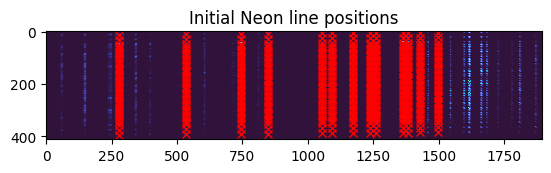

In [6]:
# Find peaks in neon spectrum. Note this depends on INI_XS, INI_YS parameters of SpectrumModel object
sm.find_peaks(use_peakutils=True, thres = 0.03)

100%|██████████| 38/38 [00:01<00:00, 24.24it/s]


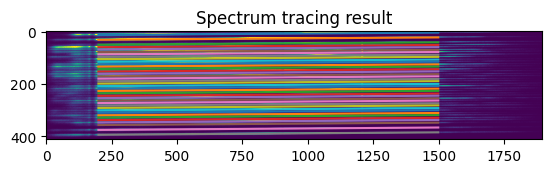

In [7]:
# Trace spectra. ini_wav_ind is the starting neon line index of the tracing.
ini_wav_ind = 3
sm.trace_spectra(ini_wav_ind)

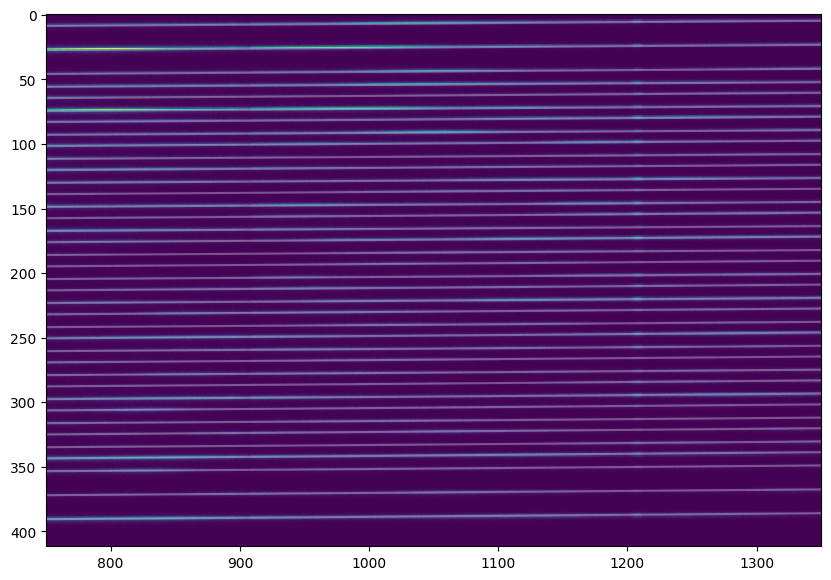

In [8]:
# closer in look to check if the traces are good
plt.figure(figsize=(10,10))
plt.imshow(sm.flat)
plt.xlim([750,1350])
sm.plot_traces()



/home/first/yjkim/PLred/PLred/imageutils.py:74: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(parabolic_2d, (x_coords, y_coords), intensities, p0=initial_guess) #,


fibind 3, wavind 0 failed
operands could not be broadcast together with shapes (0,6) (11,6) (0,6) 
fibind 4, wavind 0 failed
operands could not be broadcast together with shapes (0,6) (11,6) (0,6) 
cutout image is not centered. 3.27, 2.00
fibind 5, wavind 9 failed
fibind 6, wavind 0 failed
operands could not be broadcast together with shapes (13,9) (14,9) (13,9) 
cutout image is not centered. -36.02, -11.92
fibind 6, wavind 10 failed
fibind 8, wavind 0 failed
operands could not be broadcast together with shapes (0,6) (11,6) (0,6) 
cutout image is not centered. 1.58, 0.54
fibind 9, wavind 10 failed
fibind 10, wavind 0 failed
operands could not be broadcast together with shapes (0,6) (11,6) (0,6) 
fibind 13, wavind 0 failed
operands could not be broadcast together with shapes (2,8) (16,8) (2,8) 
cutout image is not centered. 1.82, 0.37
fibind 16, wavind 10 failed
cutout image is not centered. -1.16, -0.42
fibind 17, wavind 8 failed
fibind 18, wavind 0 failed
operands could not be broadca

/home/first/yjkim/PLred/PLred/visPLred/spec.py:554: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(ncols=self.NWAV, figsize=(self.NWAV * 2, 2))


fibind 22, wavind 0 failed
operands could not be broadcast together with shapes (0,6) (11,6) (0,6) 
fibind 23, wavind 0 failed
operands could not be broadcast together with shapes (0,6) (11,6) (0,6) 
cutout image is not centered. -1.10, -1.64
fibind 26, wavind 7 failed
fibind 27, wavind 0 failed
operands could not be broadcast together with shapes (0,6) (11,6) (0,6) 
cutout image is not centered. -1.85, -2.18
fibind 27, wavind 7 failed
fibind 30, wavind 0 failed
operands could not be broadcast together with shapes (0,6) (11,6) (0,6) 
fibind 32, wavind 0 failed
operands could not be broadcast together with shapes (0,6) (11,6) (0,6) 


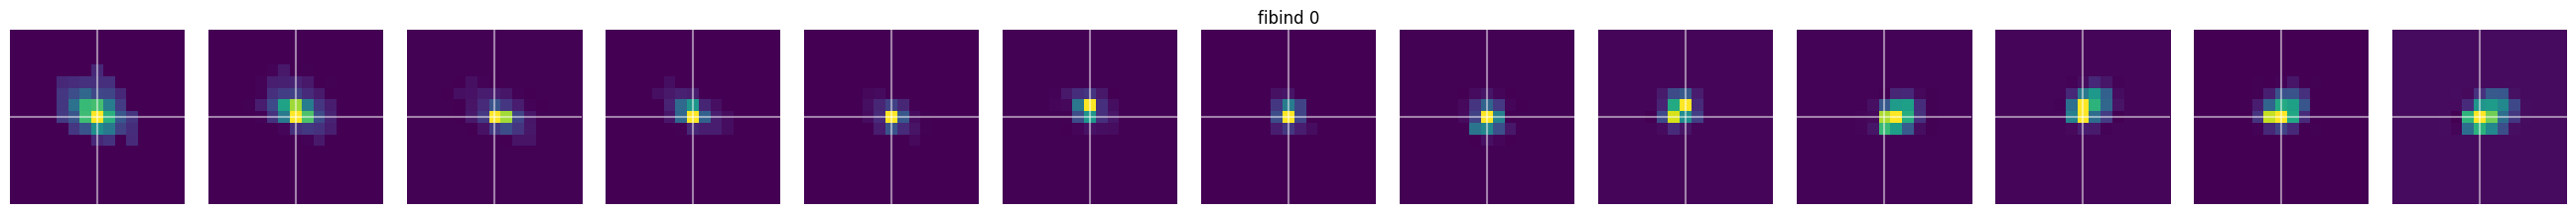

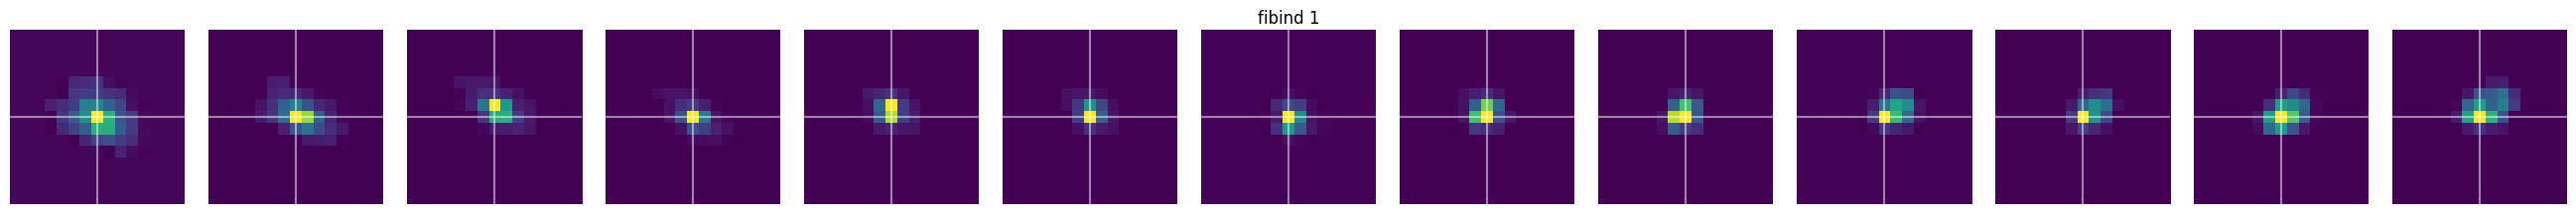

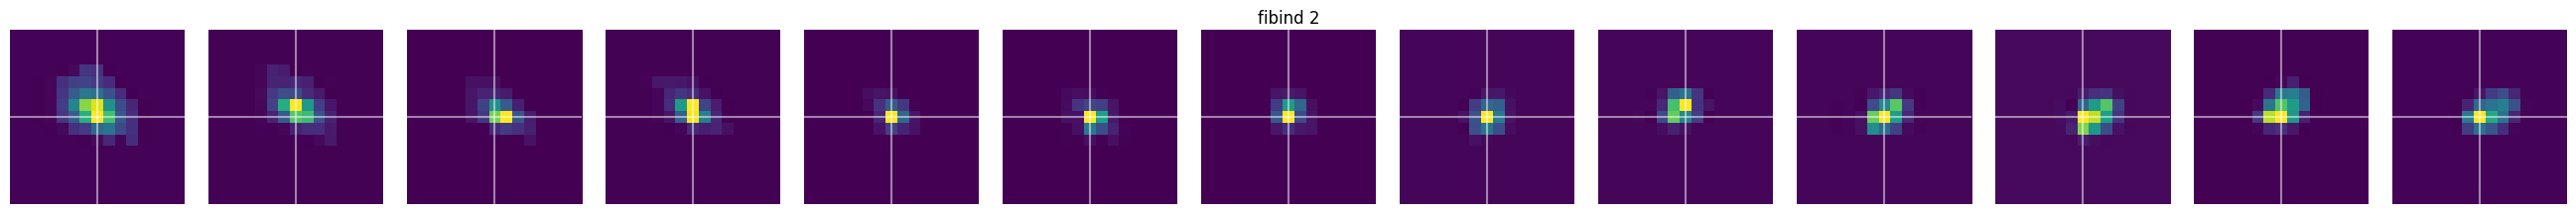

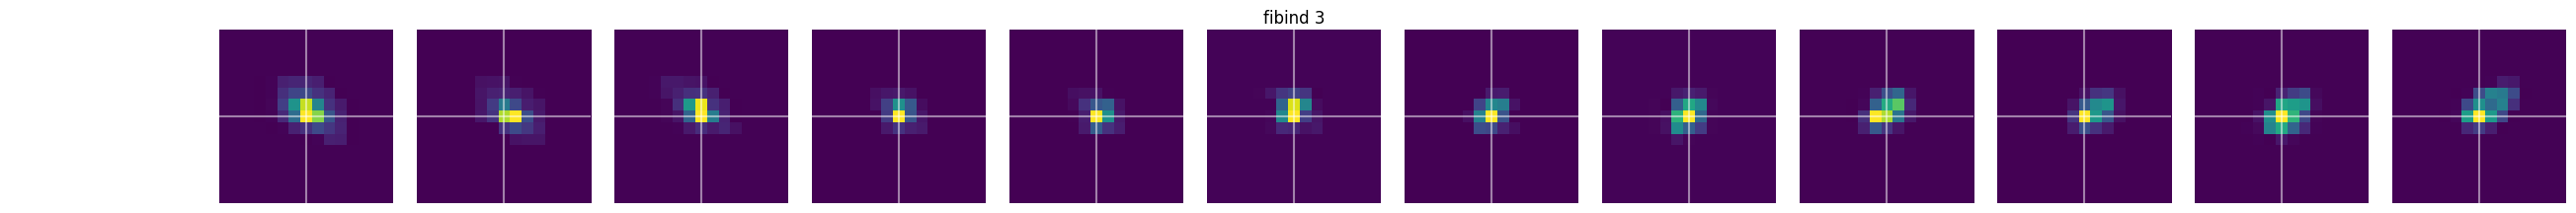

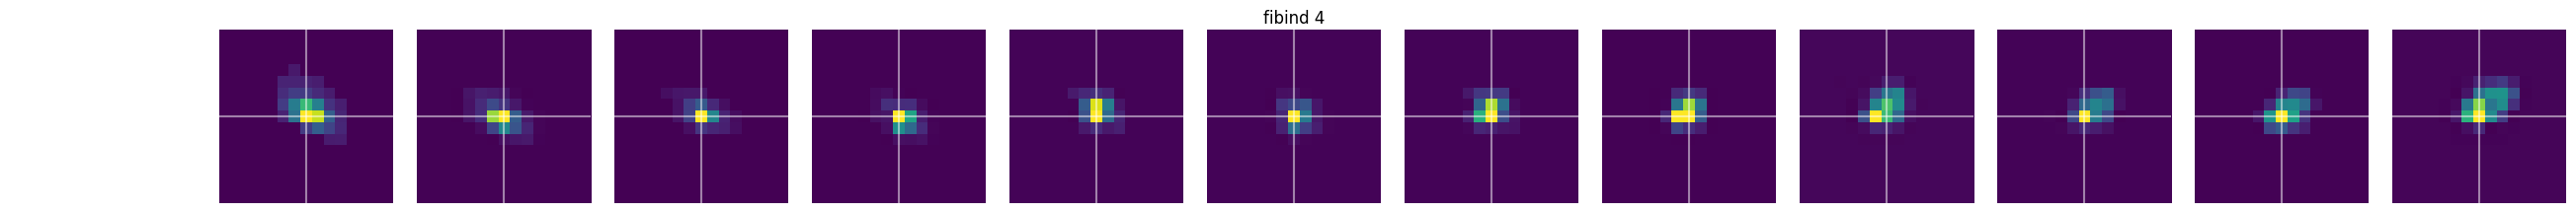

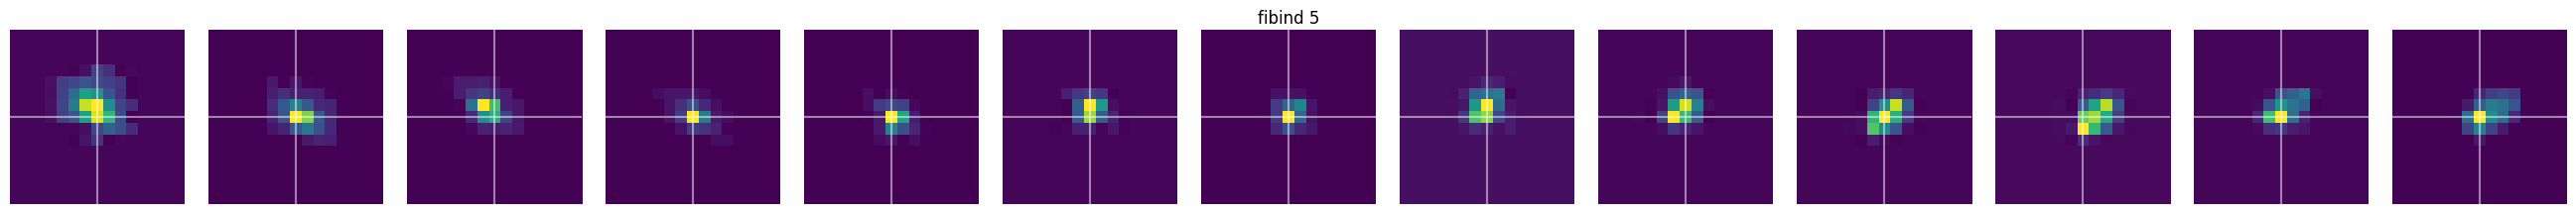

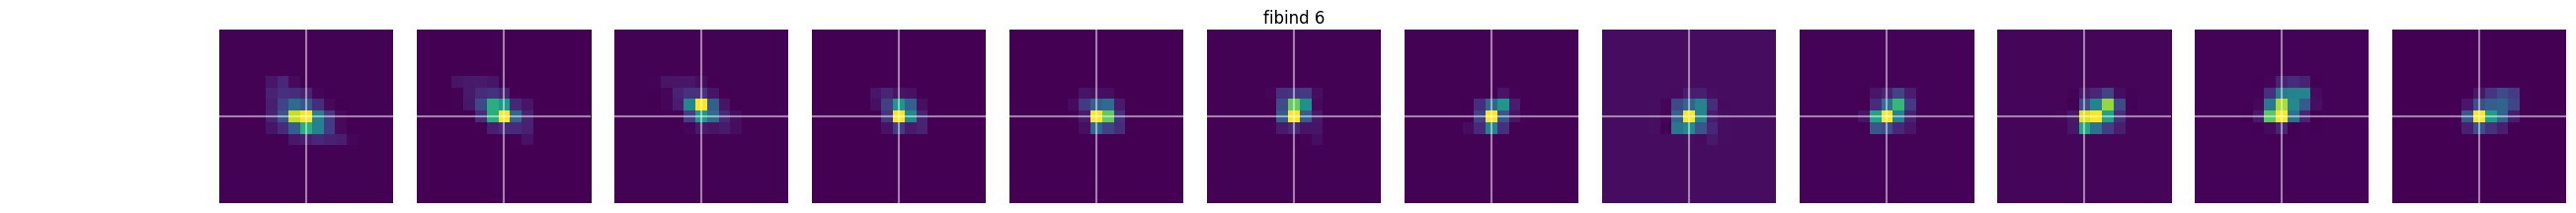

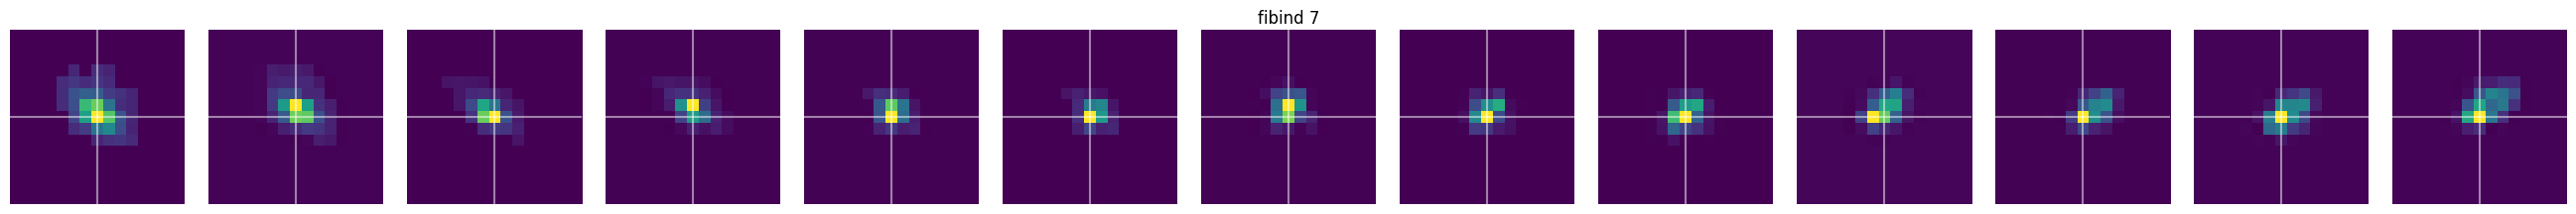

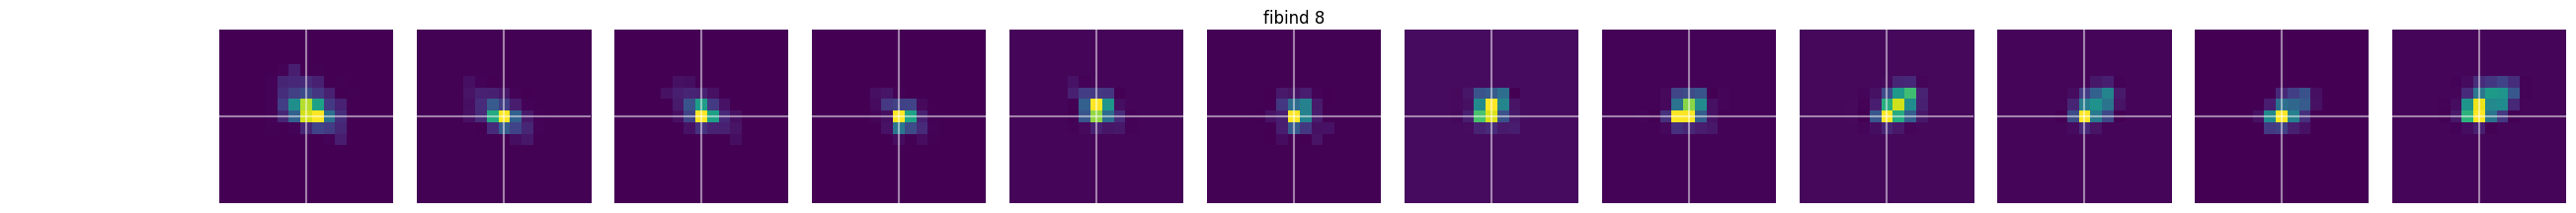

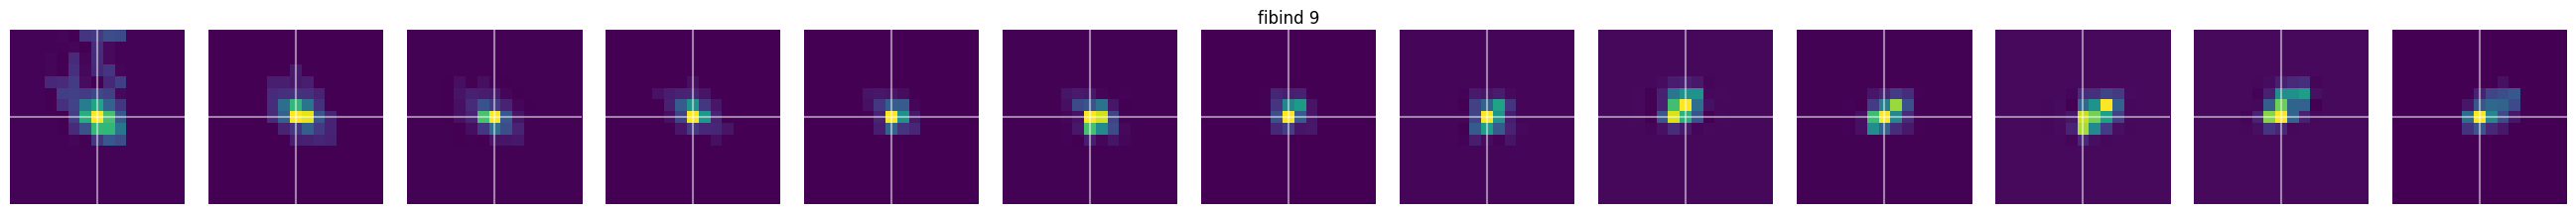

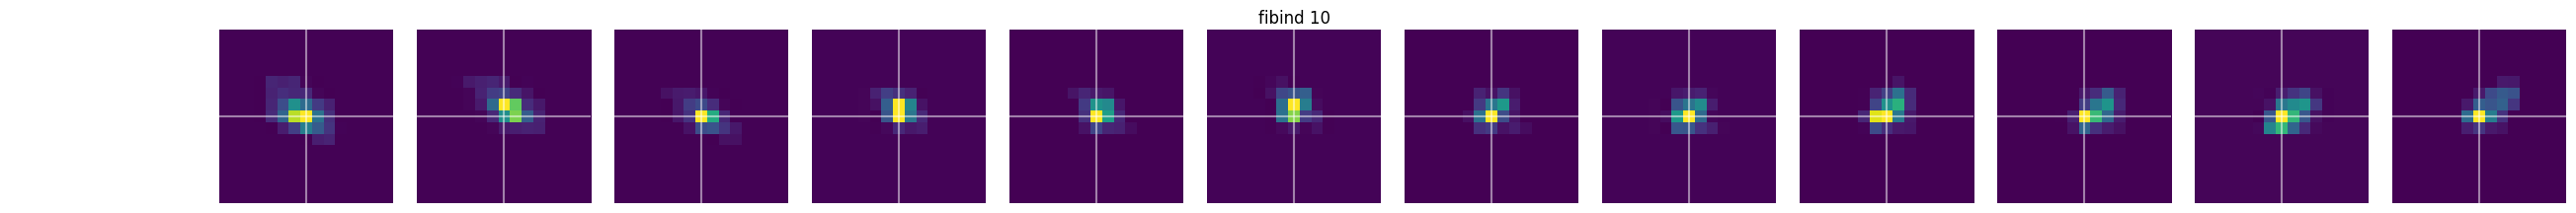

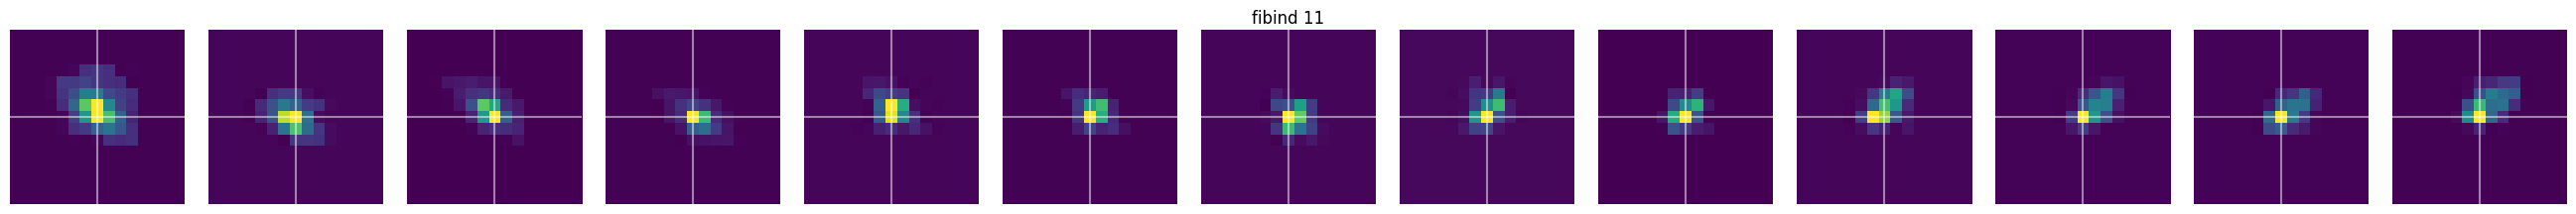

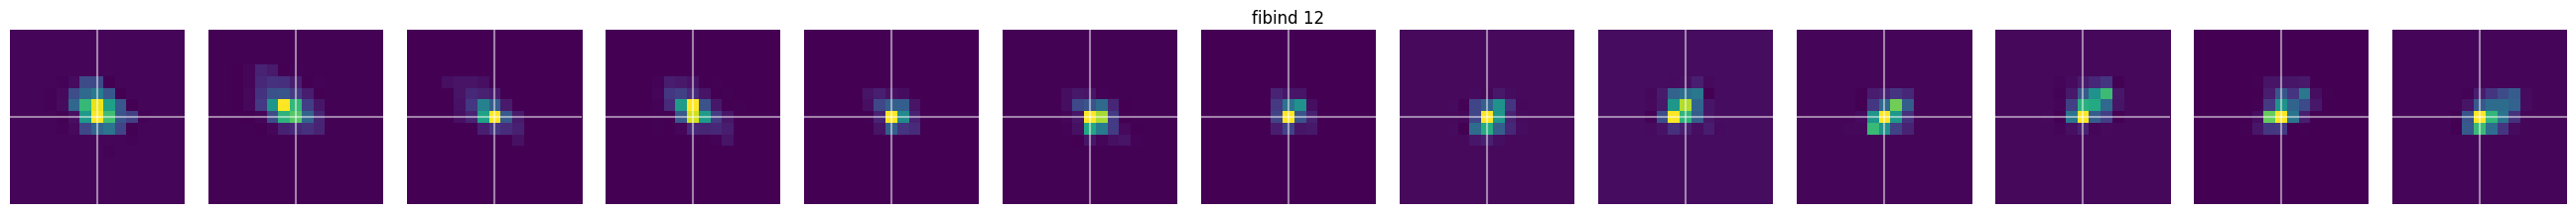

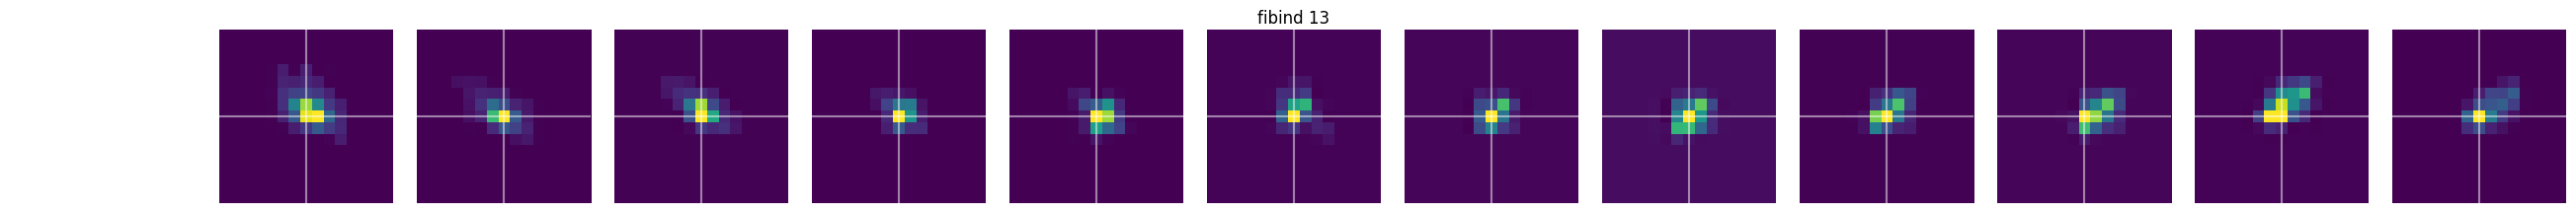

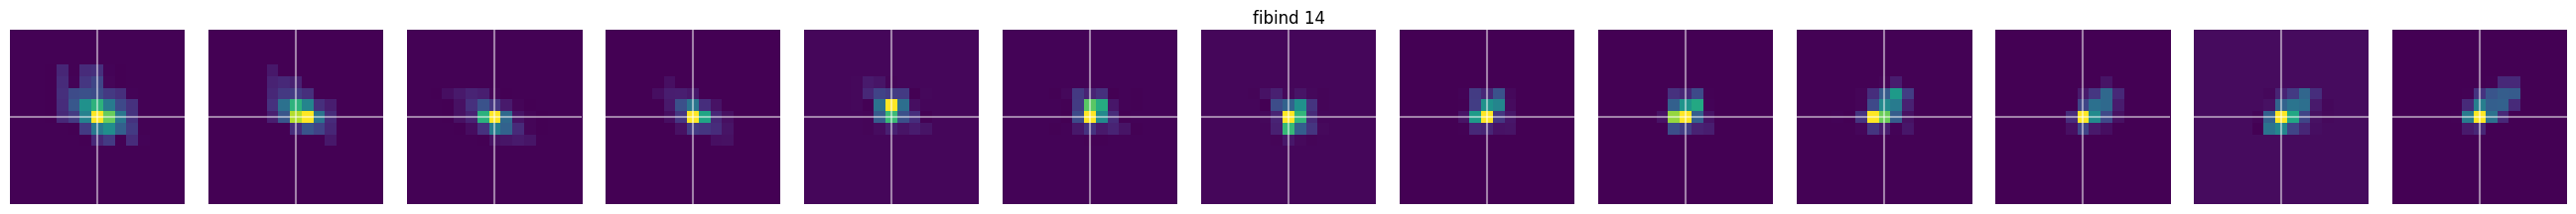

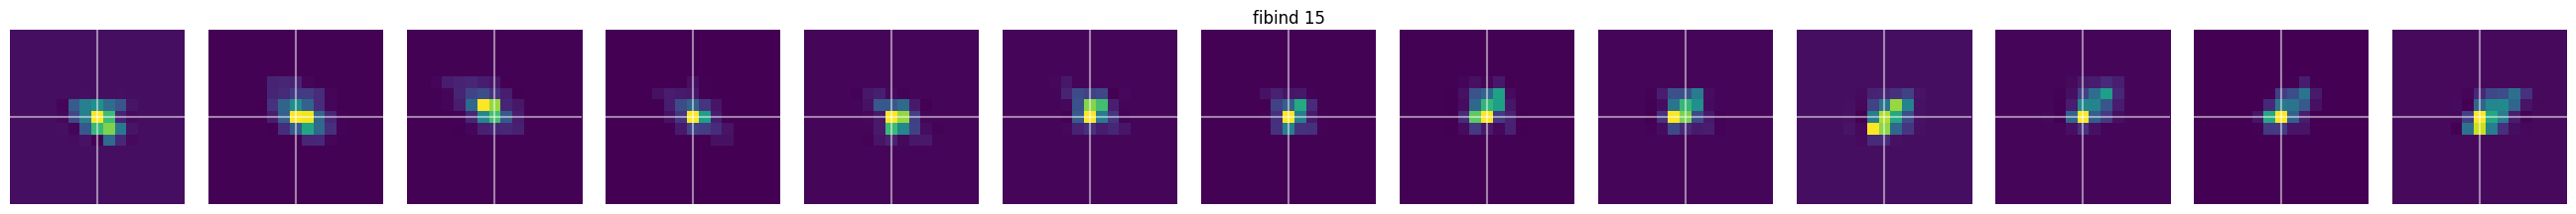

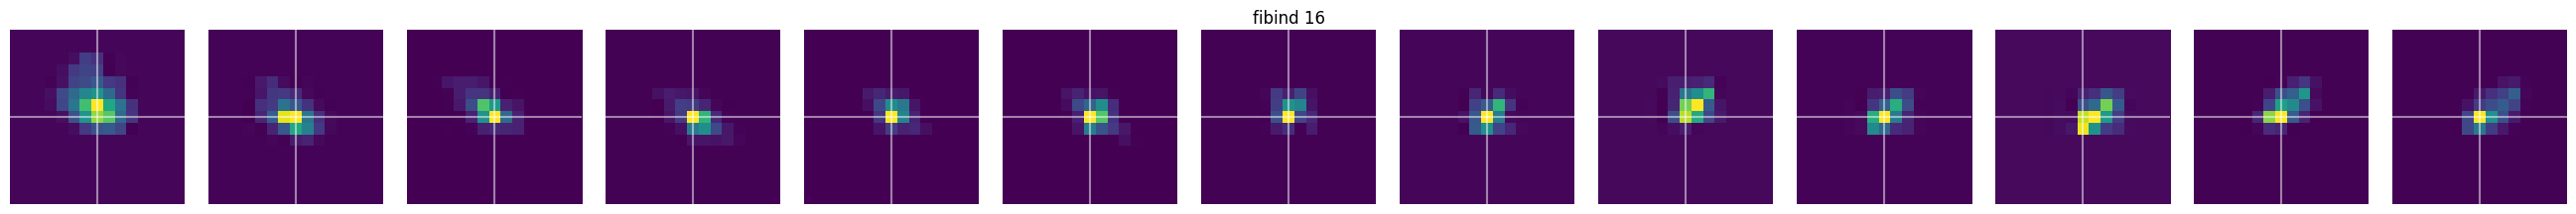

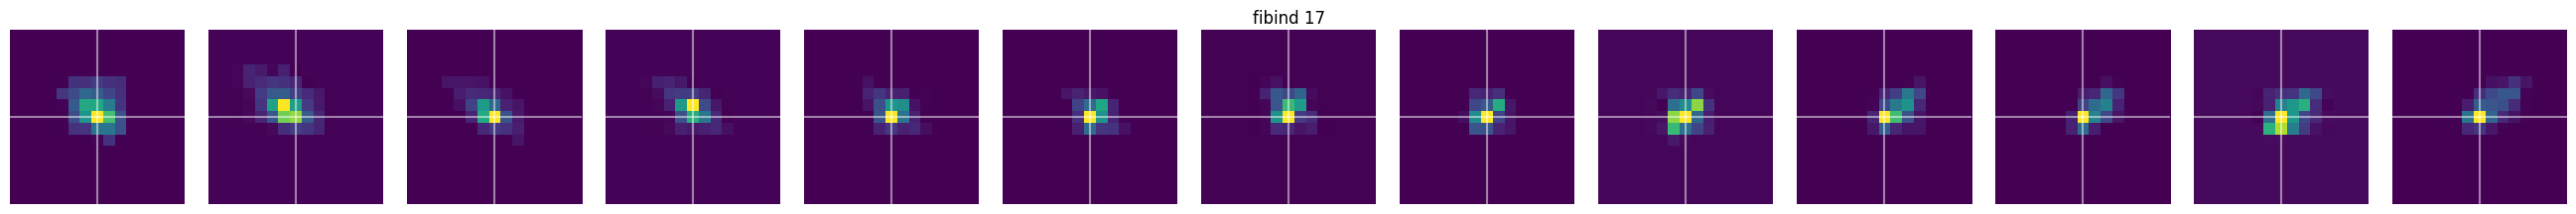

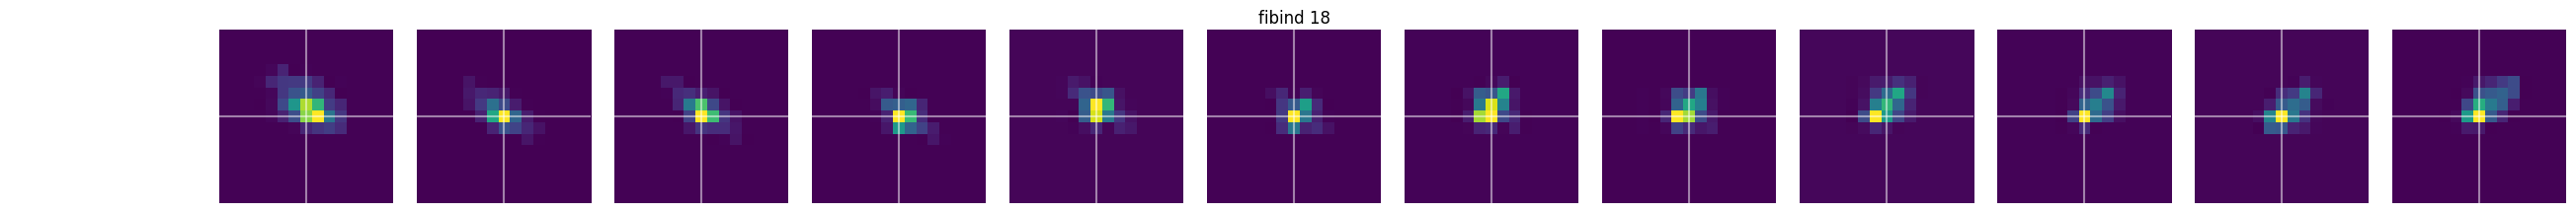

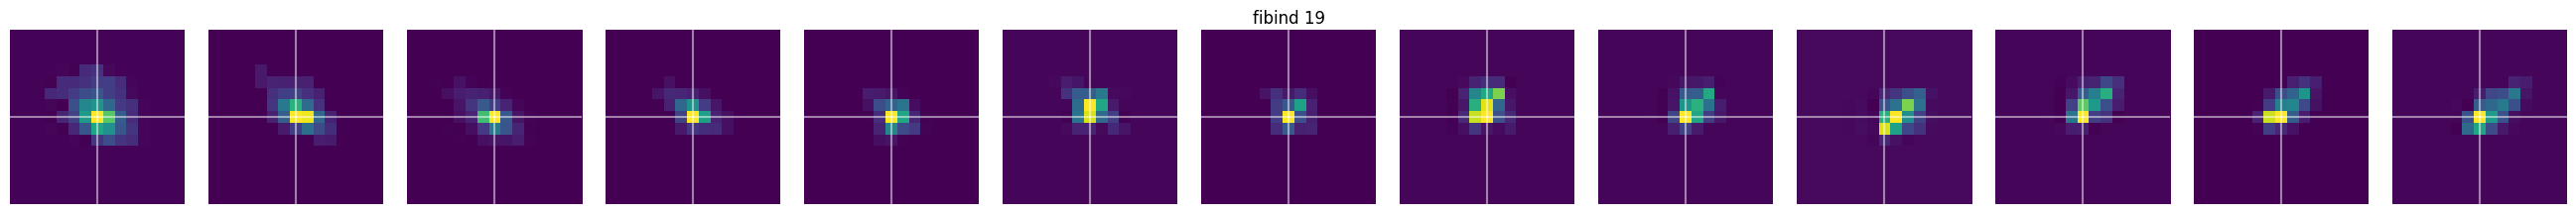

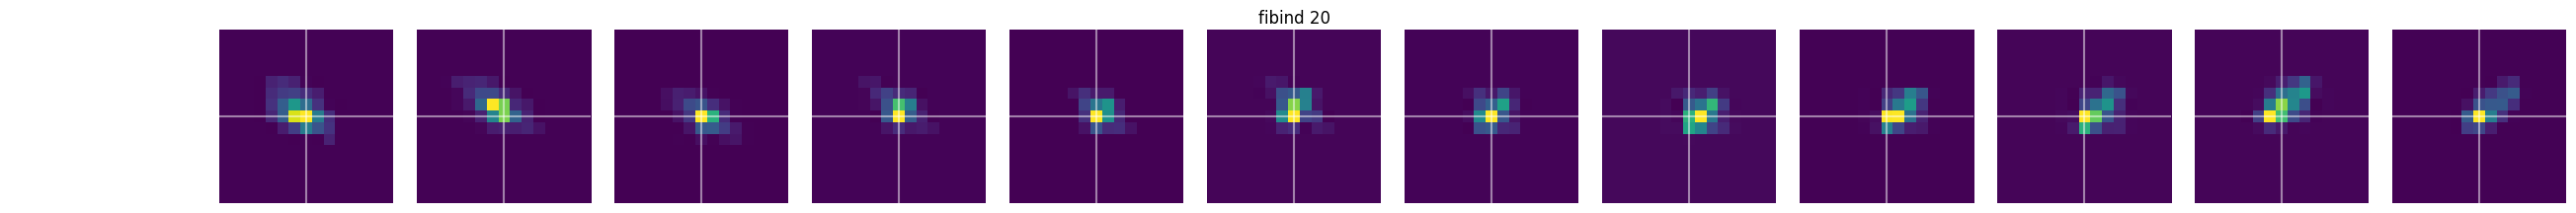

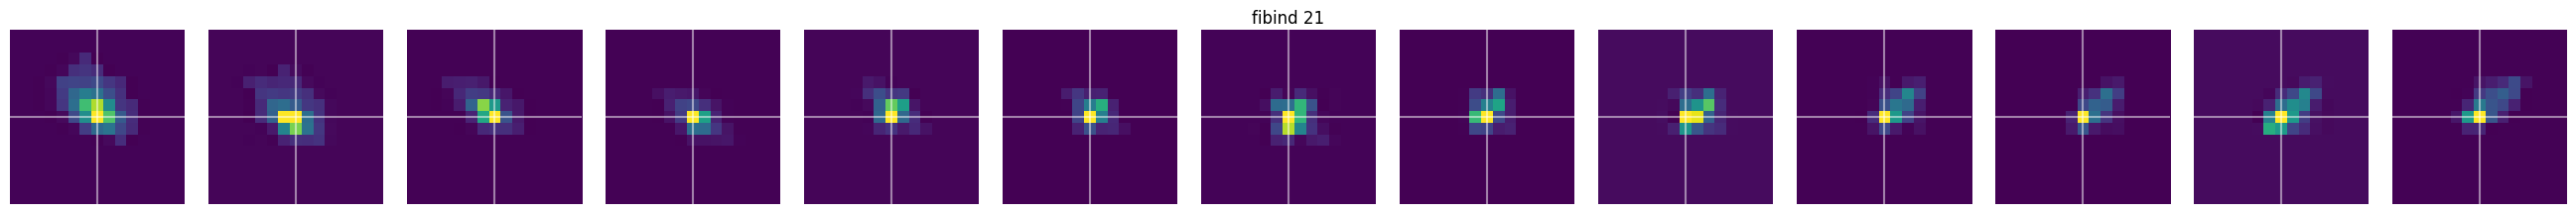

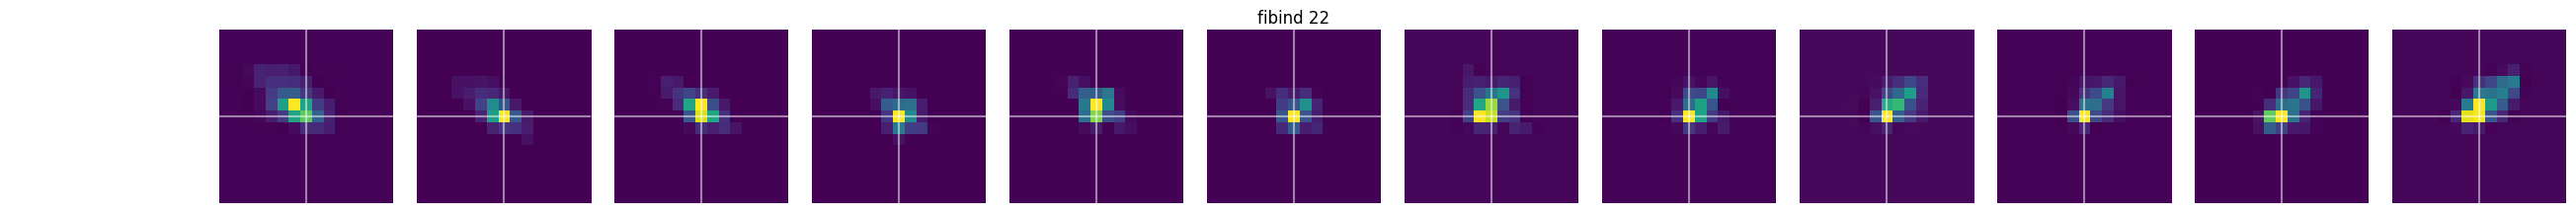

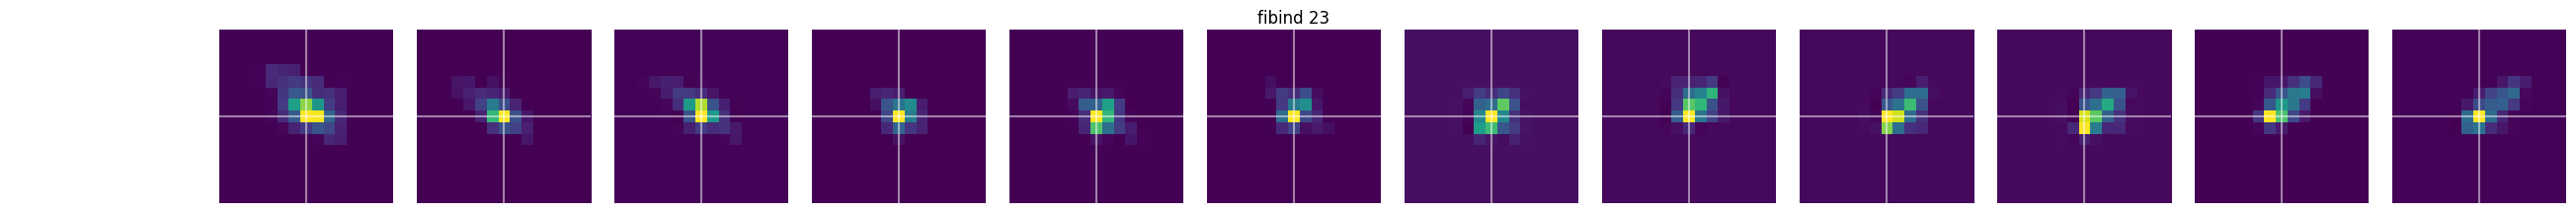

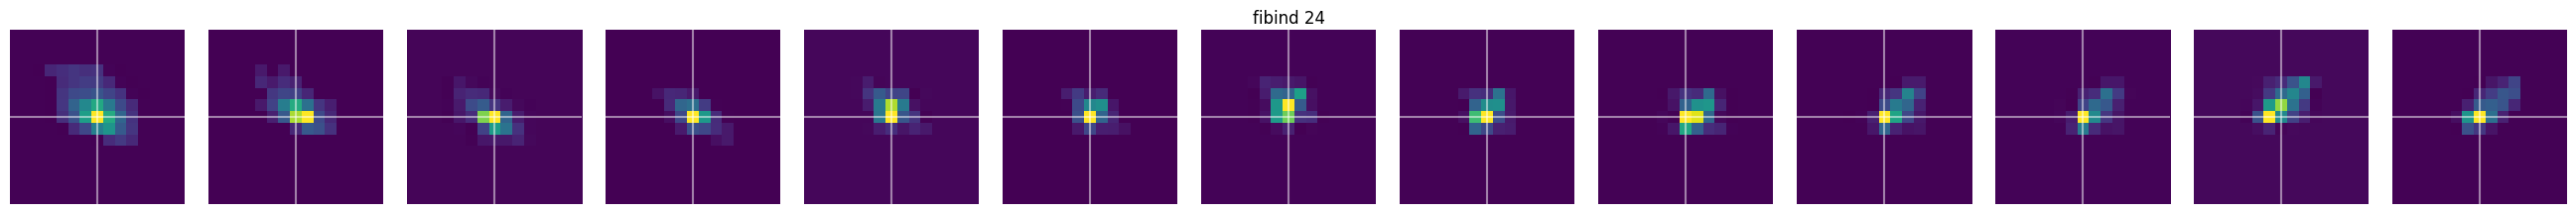

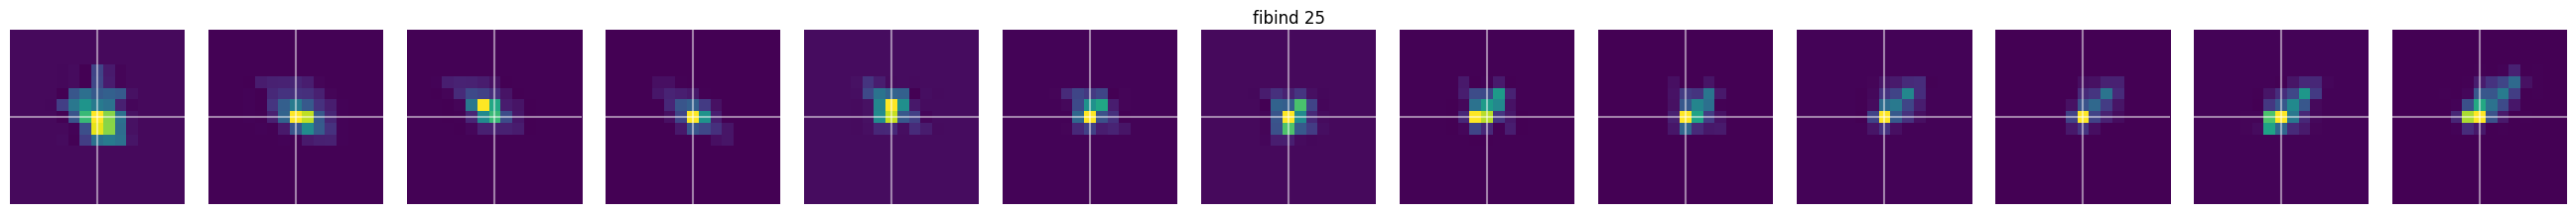

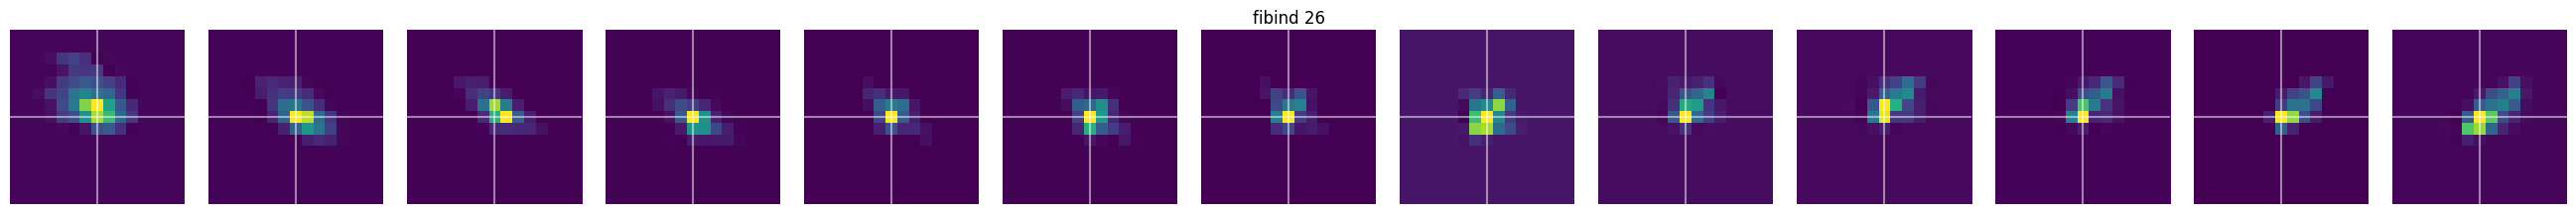

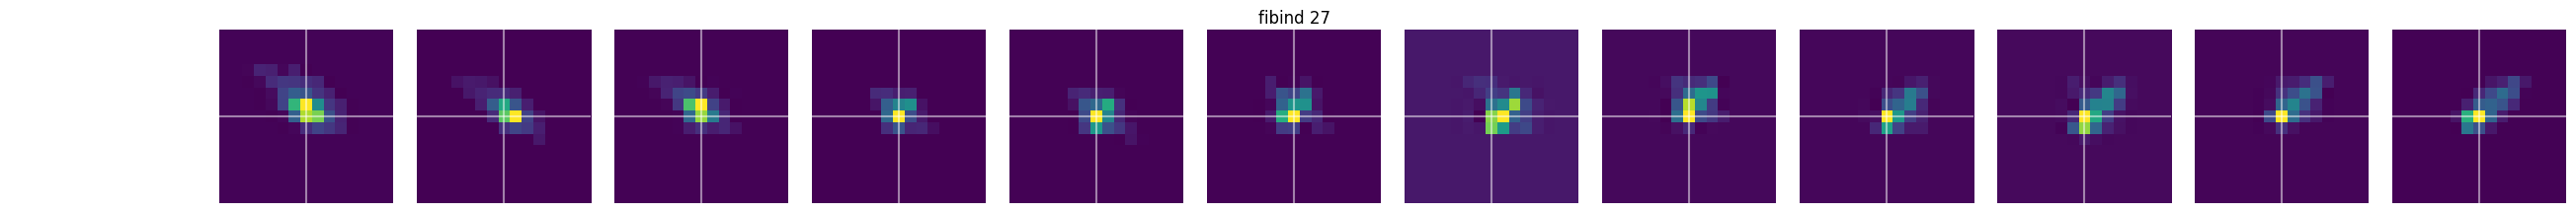

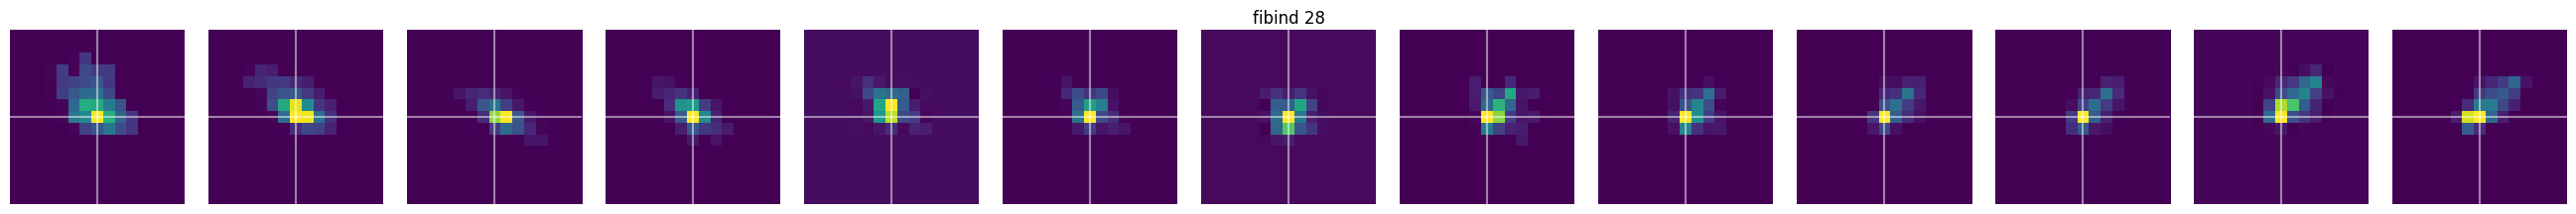

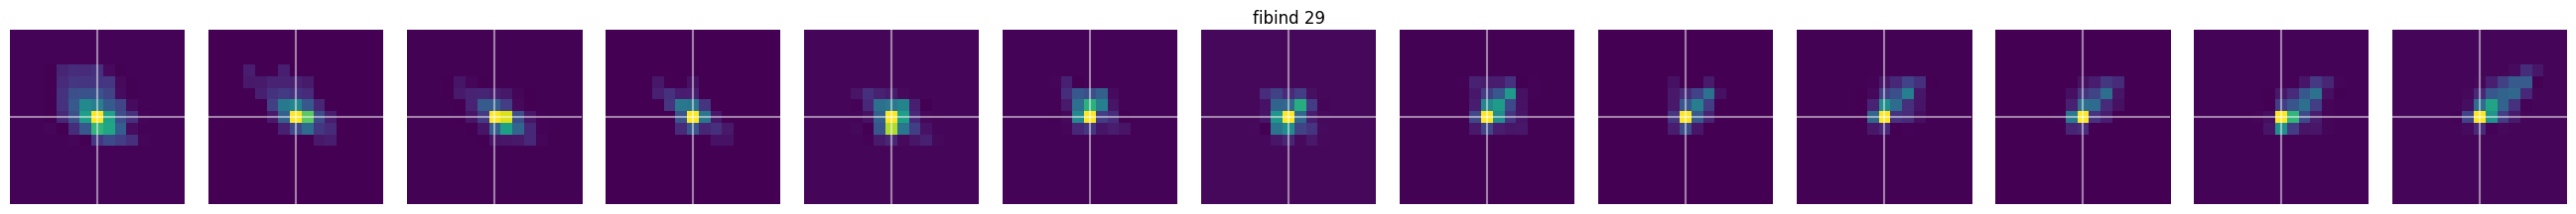

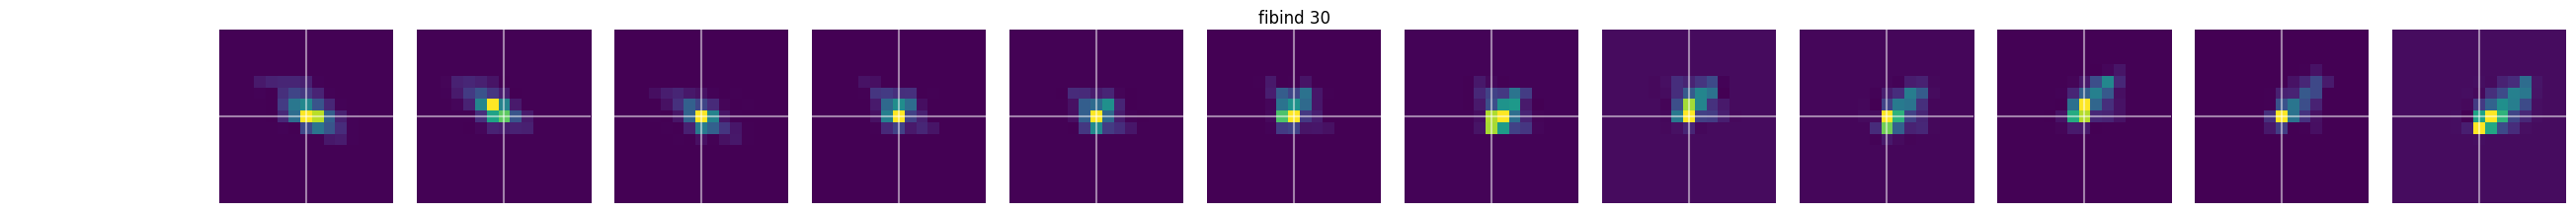

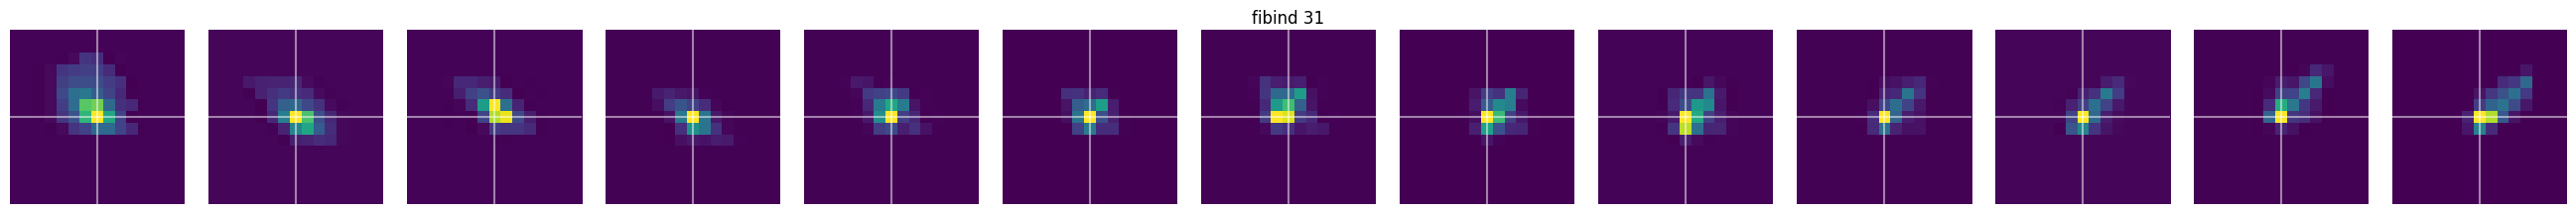

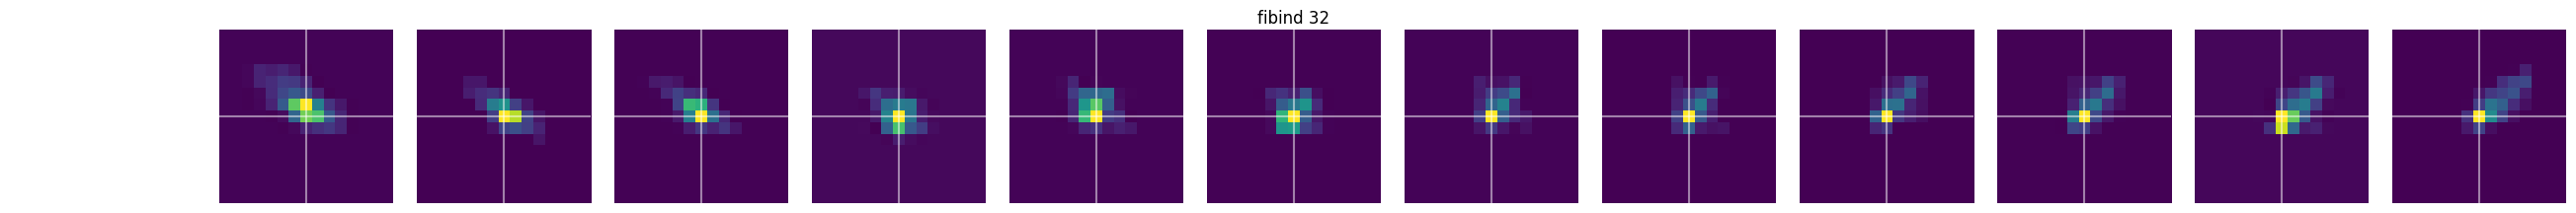

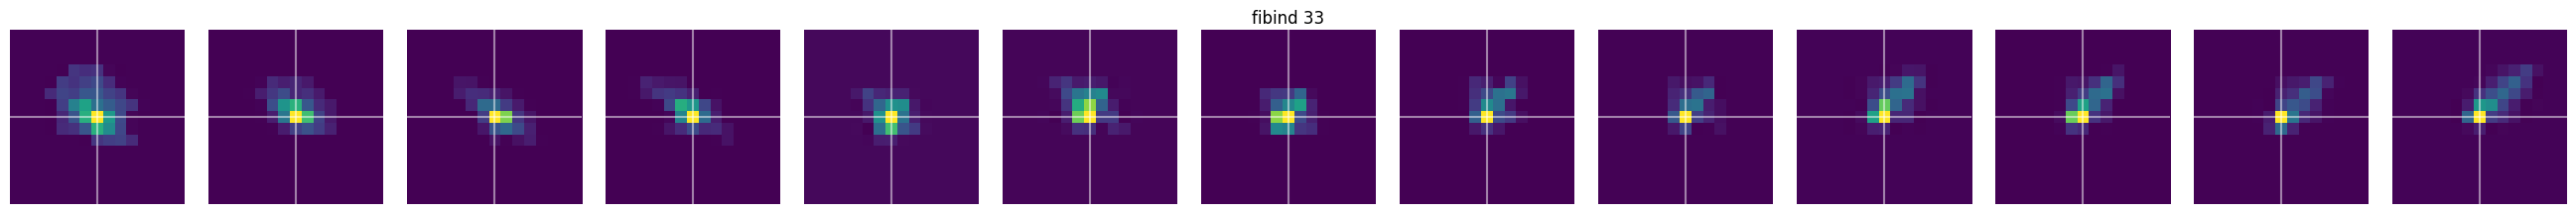

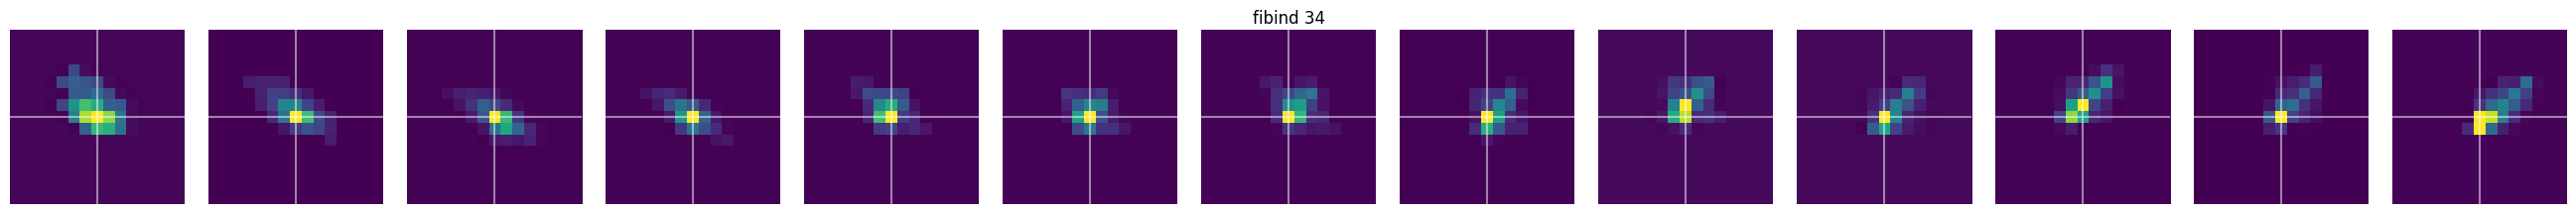

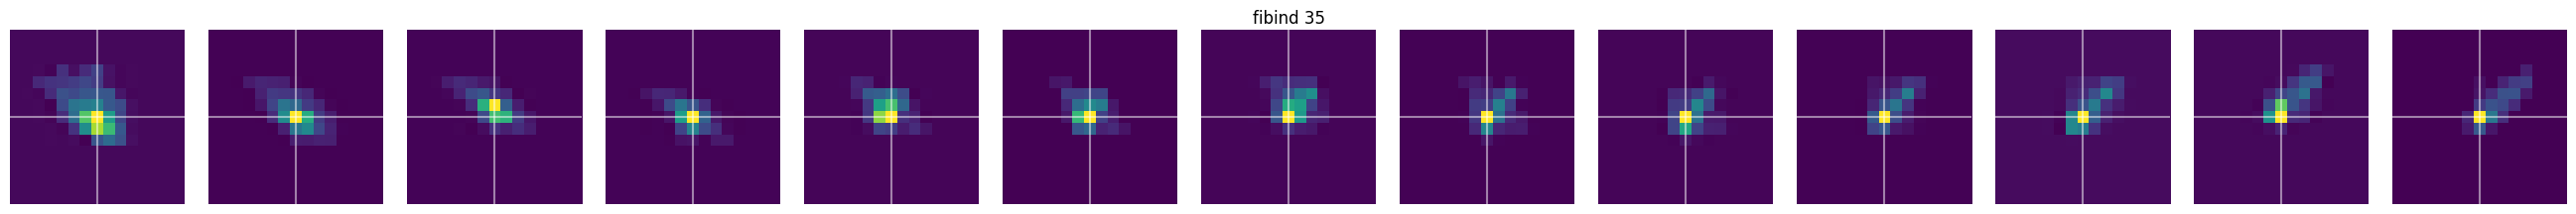

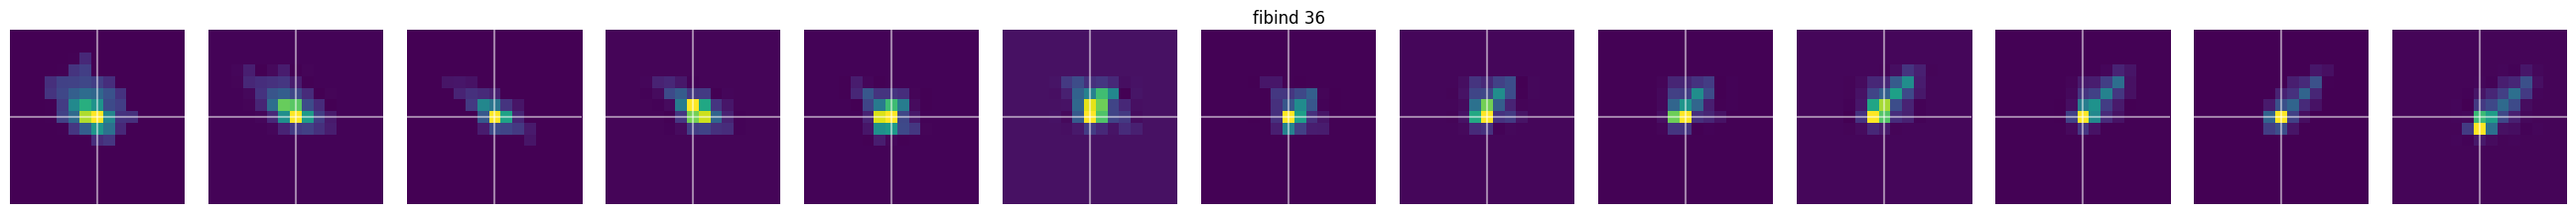

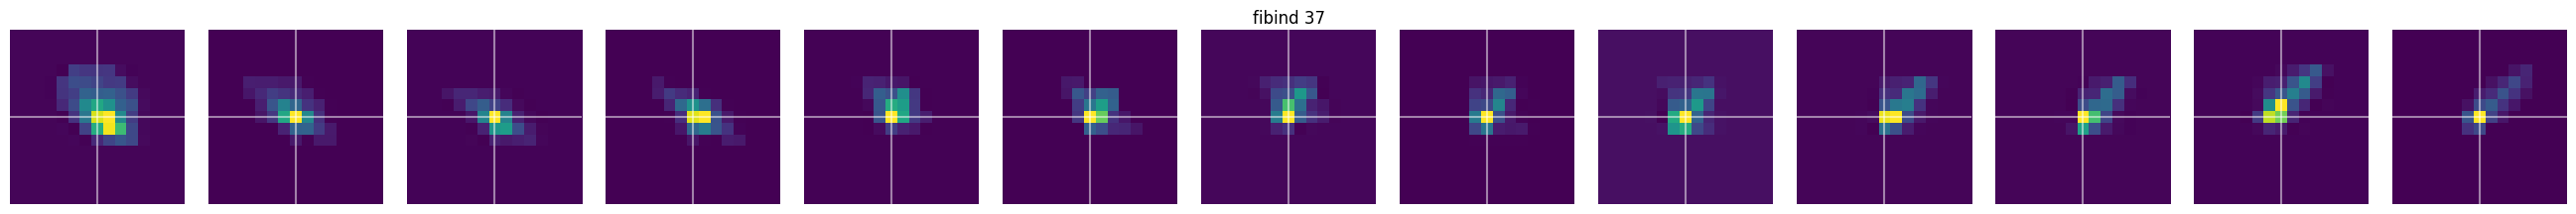

In [9]:
# Make cutout LSFs for LSF modeling
sm.make_clean_LSF_models(blob_thres=8e-3)

constructing initial matrix


100%|██████████| 38/38 [01:59<00:00,  3.15s/it]


constructing matrix for iter 1


100%|██████████| 38/38 [01:59<00:00,  3.14s/it]


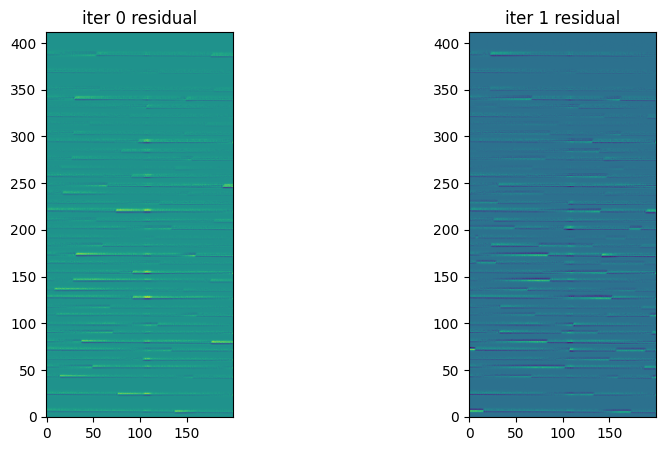

In [10]:
# LSFs are not very well centered, but we will correct for this iteratively.
# Also we will discard long wavelengths (small x) where LSF images are not well defined.

# Define wavelength range for spectral extraction. 
xmin, xmax = 1100, 1300 # pix

# Construct matrices. Note this takes a while. (for 300 pixels wide, it takes about 12 minutes for iteration 3)
matrices, ycorr_maps, recons, im = sm.iter_construct_matrix(xmin, xmax, n_iter= 2)

In [11]:
# build wavelength calibration

sm.build_wavelength_solutions(np.arange(1,10), xmin, xmax, poly_deg = 3)

In [25]:
sm.save_spectra_model('model_fft')

matrix saved to ./model_fft/model_fft_matrix.npz
wavmap saved to ./model_fft/model_fft_wavmap.npy
info saved to ./model_fft/model_fft_info.npy


In [12]:
modelname = './model'
sm2 = sp.SpectrumModel(modelname)
sm2.load_spectra_model('model')

model will be saved in ./model
model loaded from ./model/model


In [13]:
xmin = 1100
xmax = 1300

In [28]:
target_chunk = fits.getdata('/mnt/datazpool/PL/20240917/firstpl/firstpl_13:40:35.900064766.fits')
target_dark_chunk =  fits.getdata('/mnt/datazpool/PL/20240917/firstpl/firstpl_13:54:16.261087916.fits')

In [14]:
# Now try spectral extraction on one of the frames

avgdark = np.mean(target_dark_chunk, axis=0)
frame = np.mean(target_chunk[:100], axis=0) - avgdark

# Extract spectrum (optimal)
spec, res = sp.frame_to_spec(frame, xmin, xmax, sm.wav_map, matrix = sm.A, return_residual = True)
spec2, res2 = sp.frame_to_spec(frame, xmin, xmax, sm2.wav_map, matrix = sm2.A, return_residual = True)

# # Extract spectrum (box)
# spec_box = extract_spec.frame_to_spec(frame, xmin, xmax, sm.wav_map, traces = np.array(sm2.trace_vals)[:,xmin - sm2.XMIN:xmax - sm2.XMIN],
#                             boxsize = 3)

In [15]:
np.shape(target_chunk)

(1000, 412, 1896)

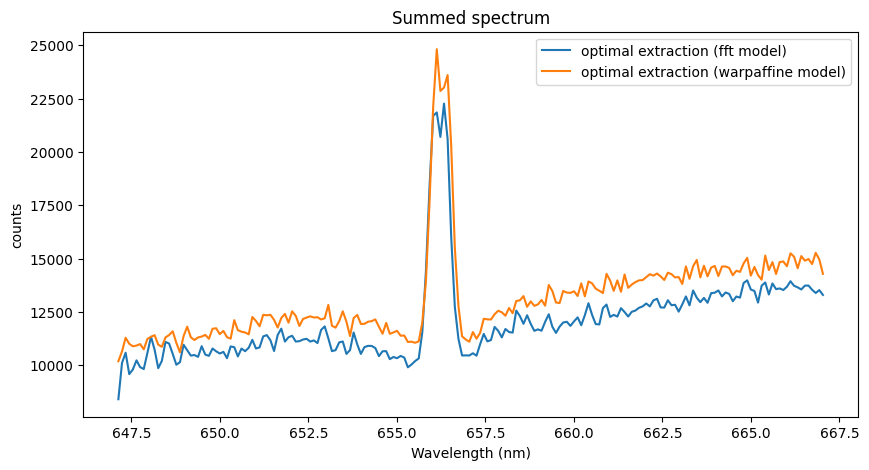

In [16]:
# Plot results (truncated 2 pixels each on the sides to avoid edge effects)

# scaler = 1.14 # to match the peak values
plt.figure(figsize=(10,5))
plt.plot(sm2.wav_map[0][2:-2], np.sum(spec, axis=0)[2:-2], label = 'optimal extraction (fft model)')
plt.plot(sm2.wav_map[0][2:-2], np.sum(spec2, axis=0)[2:-2], label = 'optimal extraction (warpaffine model)')
# plt.plot(sm.wav_map[0][2:-2], np.sum(spec_box, axis=0)[2:-2] * scaler, label = 'box extraction')
plt.xlabel('Wavelength (nm)')
plt.ylabel('counts')
plt.title('Summed spectrum')
plt.legend()

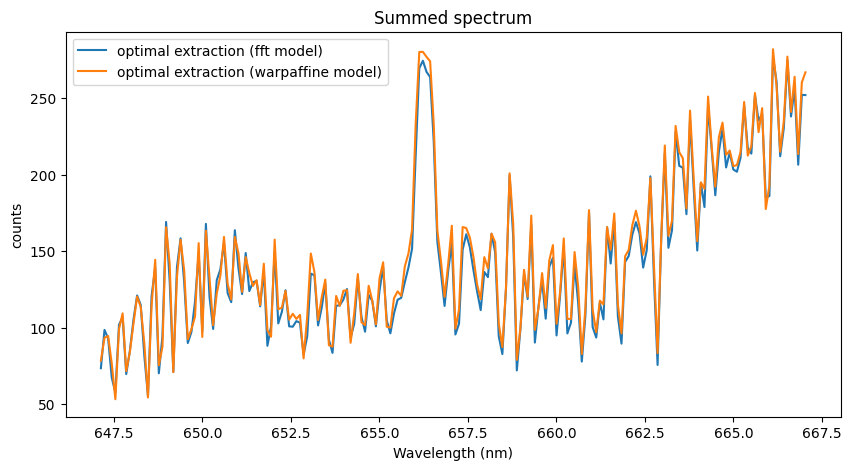

In [60]:
# Plot results (truncated 2 pixels each on the sides to avoid edge effects)
fibind = 30

# scaler = 1.14 # to match the peak values
plt.figure(figsize=(10,5))
plt.plot(sm2.wav_map[0][2:-2], (spec[fibind])[2:-2], label = 'optimal extraction (fft model)')
plt.plot(sm2.wav_map[0][2:-2], (spec2[fibind])[2:-2], label = 'optimal extraction (warpaffine model)')
# plt.plot(sm.wav_map[0][2:-2], np.sum(spec_box, axis=0)[2:-2] * scaler, label = 'box extraction')
plt.xlabel('Wavelength (nm)')
plt.ylabel('counts')
plt.title('Summed spectrum')
plt.legend()

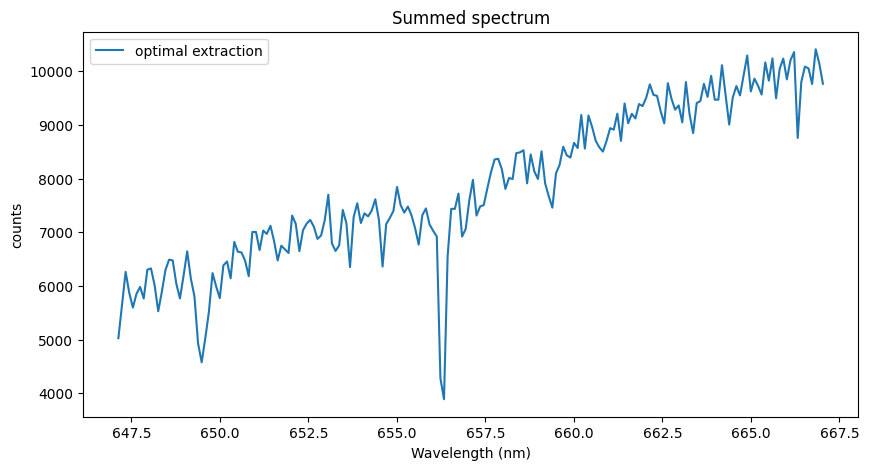

In [8]:
# Plot results (truncated 2 pixels each on the sides to avoid edge effects)

# scaler = 1.14 # to match the peak values
plt.figure(figsize=(10,5))
plt.plot(sm2.wav_map[0][2:-2], np.sum(spec, axis=0)[2:-2], label = 'optimal extraction')
# plt.plot(sm.wav_map[0][2:-2], np.sum(spec_box, axis=0)[2:-2] * scaler, label = 'box extraction')
plt.xlabel('Wavelength (nm)')
plt.ylabel('counts')
plt.title('Summed spectrum')
plt.legend()

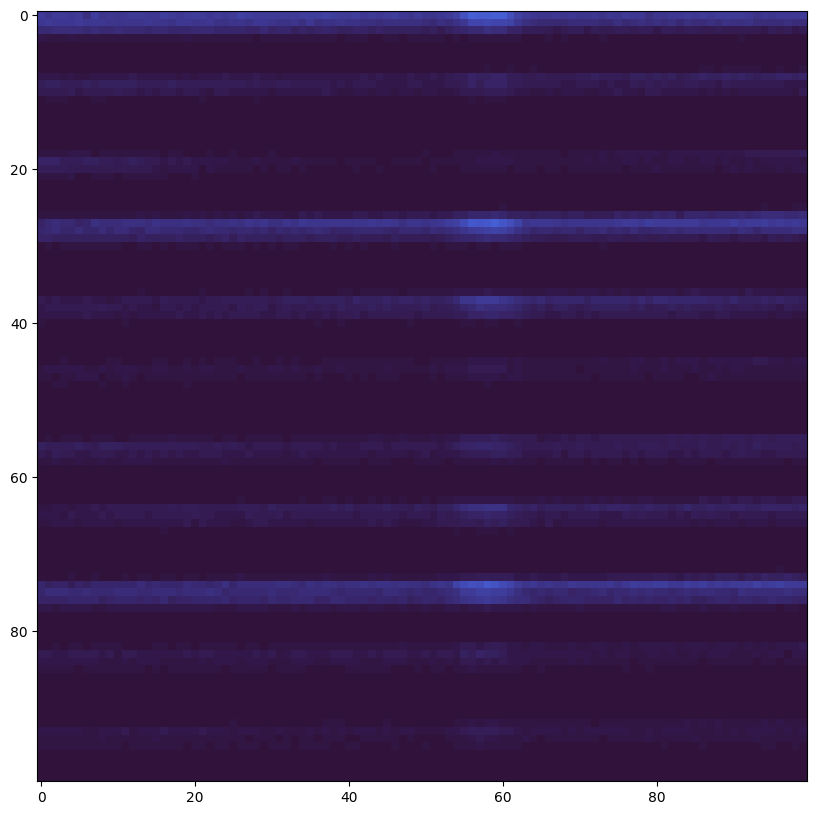

In [56]:
# The double peak feature in optimal extraction is real. check out the raw frames to see this feature.

plt.figure(figsize=(10,10))
plt.imshow(frame[220:320,1200-50:1200+50], cmap='turbo', vmax=4000)


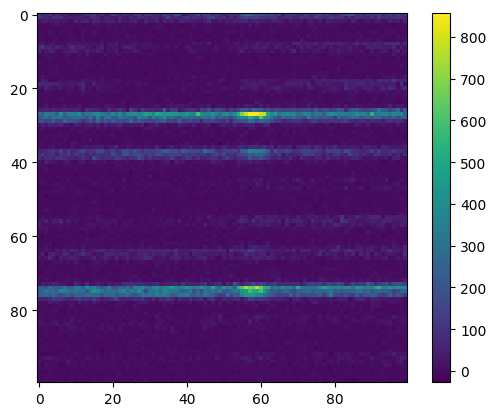

In [13]:
plt.figure(figsize=(10,10))

plt.imshow((target_chunk[0] - avgdark)[220:320,1200-50:1200+50])
plt.colorbar()

In [17]:
flatspec = (spec.flatten())

In [18]:
out = flatspec @ sm.A
out2 = flatspec @ sm2.A

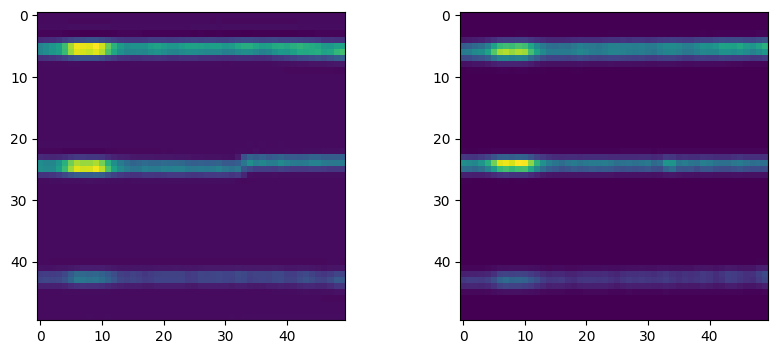

In [19]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
axs[0].imshow(out.reshape((412,200))[:50,100:150])
axs[1].imshow(out2.reshape((412,200))[:50,100:150])

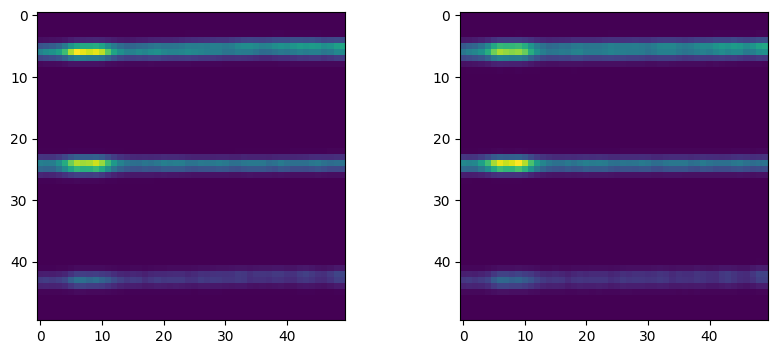

In [51]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
axs[0].imshow(out.reshape((412,200))[:50,100:150])
axs[1].imshow(out2.reshape((412,200))[:50,100:150])

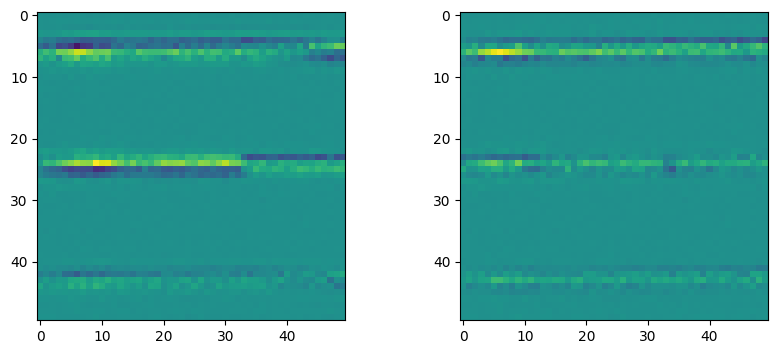

In [20]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
axs[0].imshow(frame[:,1100:1300][:50,100:150]-out.reshape((412,200))[:50,100:150],vmin=-100,vmax=100)
axs[1].imshow(frame[:,1100:1300][:50,100:150]-out2.reshape((412,200))[:50,100:150],vmin=-100,vmax=100)

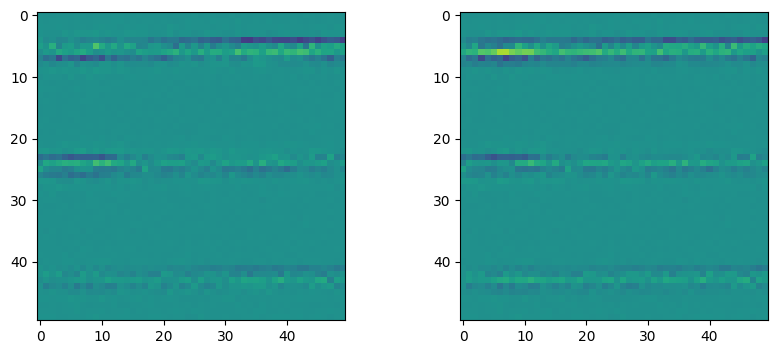

In [52]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
axs[0].imshow(frame[:,1100:1300][:50,100:150]-out.reshape((412,200))[:50,100:150],vmin=-100,vmax=100)
axs[1].imshow(frame[:,1100:1300][:50,100:150]-out2.reshape((412,200))[:50,100:150],vmin=-100,vmax=100)

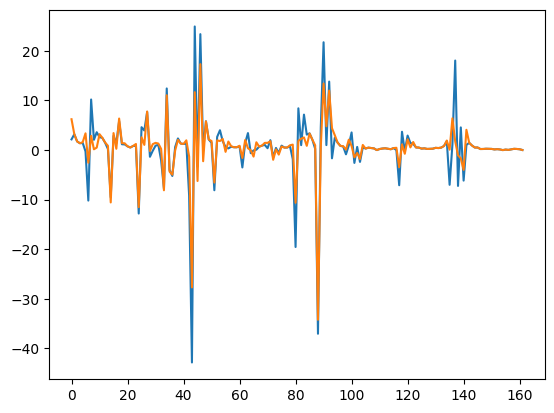

In [57]:
plt.plot(np.average(frame[:,1100:1300][250:,100:150]-out2.reshape((412,200))[250:,100:150],axis=1))
plt.plot(np.average(frame[:,1100:1300][250:,100:150]-out.reshape((412,200))[250:,100:150],axis=1))

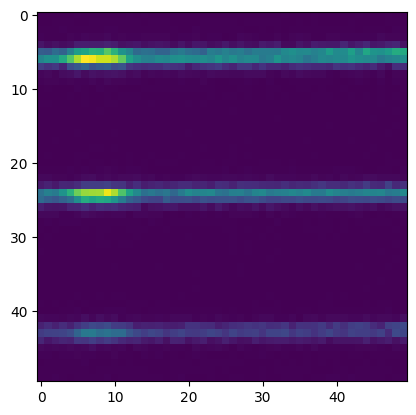

In [69]:
plt.imshow(frame[:,1100:1300][:50,100:150])


In [14]:
target_chunk2 = fits.getdata('/mnt/datazpool/PL/20240917/firstpl/firstpl_15:00:37.192645603.fits')
frame2 = np.mean(target_chunk2[:1000], axis=0) - avgdark
spec2, res2 = sp.frame_to_spec(frame2, xmin, xmax, sm2.wav_map, matrix = sm2.A, return_residual = True)
flatspec2 = (spec2.flatten())

out2 = flatspec2 @ sm2.A

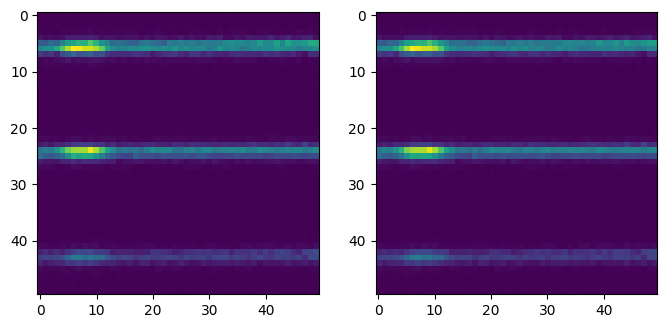

In [75]:
fig, axs = plt.subplots(ncols=2, figsize=(8,4))

axs[0].imshow(frame[:,1100:1300][:50,100:150])

axs[1].imshow(frame2[:,1100:1300][:50,100:150])


/tmp/ipykernel_1483775/3539596111.py:3: RuntimeWarning: divide by zero encountered in divide
  axs[0].imshow((frame[:,1100:1300] / out.reshape((412,200)))[:50,100:150],vmin=0.5, vmax=1.5)
/tmp/ipykernel_1483775/3539596111.py:3: RuntimeWarning: invalid value encountered in divide
  axs[0].imshow((frame[:,1100:1300] / out.reshape((412,200)))[:50,100:150],vmin=0.5, vmax=1.5)
/tmp/ipykernel_1483775/3539596111.py:5: RuntimeWarning: divide by zero encountered in divide
  axs[1].imshow((frame2[:,1100:1300] / out2.reshape((412,200)))[:50,100:150],vmin=0.5, vmax=1.5)
/tmp/ipykernel_1483775/3539596111.py:5: RuntimeWarning: invalid value encountered in divide
  axs[1].imshow((frame2[:,1100:1300] / out2.reshape((412,200)))[:50,100:150],vmin=0.5, vmax=1.5)


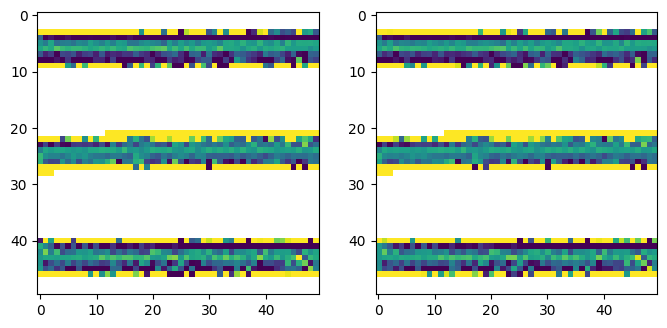

In [78]:
fig, axs = plt.subplots(ncols=2, figsize=(8,4))

axs[0].imshow((frame[:,1100:1300] / out.reshape((412,200)))[:50,100:150],vmin=0.5, vmax=1.5)

axs[1].imshow((frame2[:,1100:1300] / out2.reshape((412,200)))[:50,100:150],vmin=0.5, vmax=1.5)



/tmp/ipykernel_1483775/794242016.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.plot((frame[:,1100:1300] / out.reshape((412,200)))[7])
/tmp/ipykernel_1483775/794242016.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot((frame[:,1100:1300] / out.reshape((412,200)))[7])
/tmp/ipykernel_1483775/794242016.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot((frame2[:,1100:1300] / out2.reshape((412,200)))[7])
/tmp/ipykernel_1483775/794242016.py:2: RuntimeWarning: invalid value encountered in divide
  plt.plot((frame2[:,1100:1300] / out2.reshape((412,200)))[7])


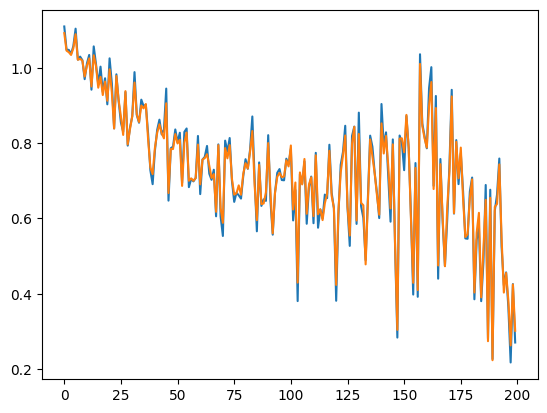

In [81]:
plt.plot((frame[:,1100:1300] / out.reshape((412,200)))[7])
plt.plot((frame2[:,1100:1300] / out2.reshape((412,200)))[7])

/tmp/ipykernel_1483775/1960683306.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.plot((frame[:,1100:1300] / out.reshape((412,200)))[6])
/tmp/ipykernel_1483775/1960683306.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot((frame[:,1100:1300] / out.reshape((412,200)))[6])
/tmp/ipykernel_1483775/1960683306.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot((frame2[:,1100:1300] / out2.reshape((412,200)))[6])
/tmp/ipykernel_1483775/1960683306.py:2: RuntimeWarning: invalid value encountered in divide
  plt.plot((frame2[:,1100:1300] / out2.reshape((412,200)))[6])


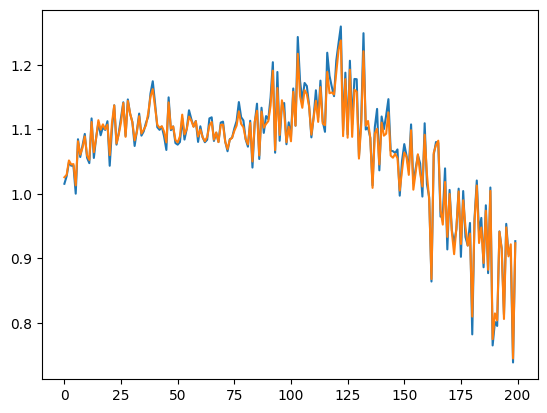

In [83]:
plt.plot((frame[:,1100:1300] / out.reshape((412,200)))[6])
plt.plot((frame2[:,1100:1300] / out2.reshape((412,200)))[6])

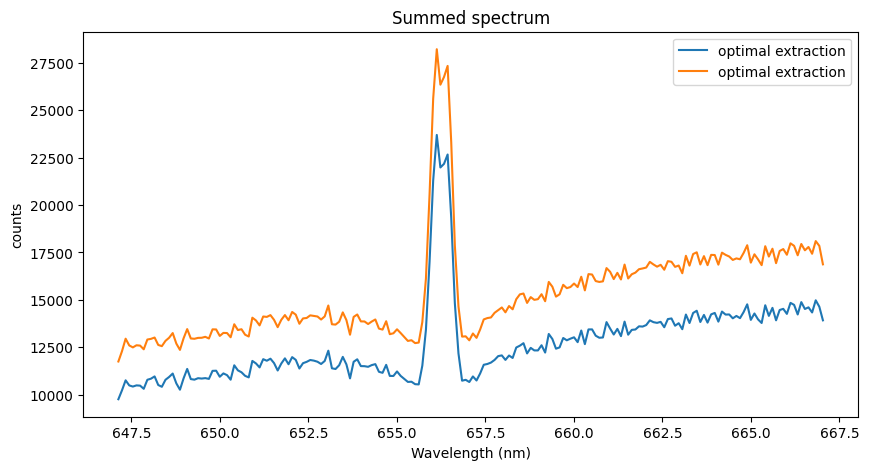

In [84]:
# Plot results (truncated 2 pixels each on the sides to avoid edge effects)

# scaler = 1.14 # to match the peak values
plt.figure(figsize=(10,5))
plt.plot(sm.wav_map[0][2:-2], np.sum(spec, axis=0)[2:-2], label = 'optimal extraction')
plt.plot(sm.wav_map[0][2:-2], np.sum(spec2, axis=0)[2:-2], label = 'optimal extraction')
# plt.plot(sm.wav_map[0][2:-2], np.sum(spec_box, axis=0)[2:-2] * scaler, label = 'box extraction')
plt.xlabel('Wavelength (nm)')
plt.ylabel('counts')
plt.title('Summed spectrum')
plt.legend()

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(8,4))

axs[0].imshow((frame[:,1100:1300] / out.reshape((412,200)))[:50,100:150],vmin=0.5, vmax=1.5)

axs[1].imshow((frame2[:,1100:1300] / out2.reshape((412,200)))[:50,100:150],vmin=0.5, vmax=1.5)



In [15]:
target_chunk3 = fits.getdata('/mnt/datazpool/PL/20240917/firstpl/firstpl_15:00:57.201428263.fits')
frame3 = np.mean(target_chunk3[:1000], axis=0) - avgdark
spec3, res3 = sp.frame_to_spec(frame3, xmin, xmax, sm2.wav_map, matrix = sm2.A, return_residual = True)
flatspec3 = (spec3.flatten())

out3 = flatspec3 @ sm2.A

In [16]:
target_chunk4 = fits.getdata('/mnt/datazpool/PL/20240917/firstpl/firstpl_15:01:17.210261881.fits')
frame4 = np.mean(target_chunk4[:1000], axis=0) - avgdark
spec4, res4 = sp.frame_to_spec(frame4, xmin, xmax, sm2.wav_map, matrix = sm2.A, return_residual = True)
flatspec4 = (spec4.flatten())

out4 = flatspec4 @ sm2.A

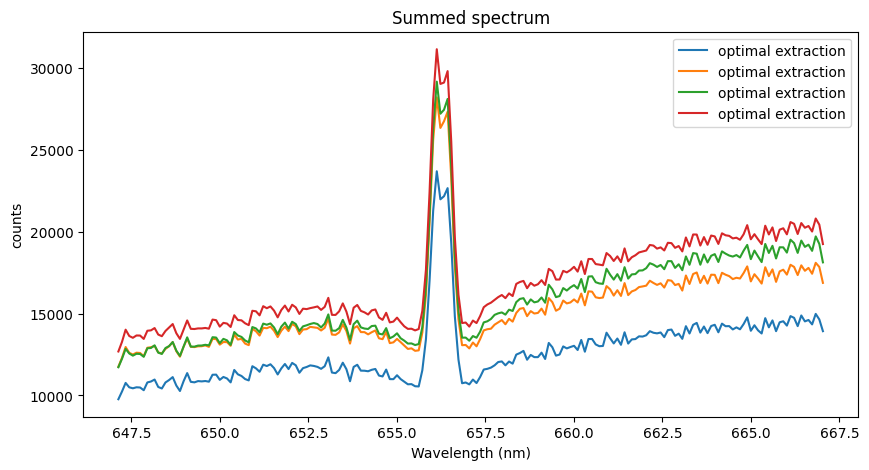

In [96]:
# Plot results (truncated 2 pixels each on the sides to avoid edge effects)

# scaler = 1.14 # to match the peak values
plt.figure(figsize=(10,5))
plt.plot(sm.wav_map[0][2:-2], np.sum(spec, axis=0)[2:-2], label = 'optimal extraction')
plt.plot(sm.wav_map[0][2:-2], np.sum(spec2, axis=0)[2:-2], label = 'optimal extraction')
plt.plot(sm.wav_map[0][2:-2], np.sum(spec3, axis=0)[2:-2], label = 'optimal extraction')
plt.plot(sm.wav_map[0][2:-2], np.sum(spec4, axis=0)[2:-2], label = 'optimal extraction')
# plt.plot(sm.wav_map[0][2:-2], np.sum(spec_box, axis=0)[2:-2] * scaler, label = 'box extraction')
plt.xlabel('Wavelength (nm)')
plt.ylabel('counts')
plt.title('Summed spectrum')
plt.legend()

/tmp/ipykernel_1483775/2551057897.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.plot((frame[:,1100:1300] / out.reshape((412,200)))[ind])
/tmp/ipykernel_1483775/2551057897.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot((frame[:,1100:1300] / out.reshape((412,200)))[ind])
/tmp/ipykernel_1483775/2551057897.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot((frame2[:,1100:1300] / out2.reshape((412,200)))[ind])
/tmp/ipykernel_1483775/2551057897.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot((frame2[:,1100:1300] / out2.reshape((412,200)))[ind])
/tmp/ipykernel_1483775/2551057897.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.plot((frame3[:,1100:1300] / out3.reshape((412,200)))[ind])
/tmp/ipykernel_1483775/2551057897.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot((frame3[:,1100:1300] / out3.reshape((412,200)))[ind])
/tmp/ipykernel_1483775/2551057897.py:6: RuntimeWarning: div

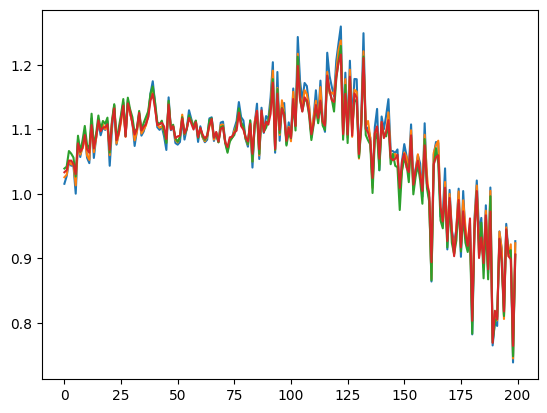

In [112]:
ind = 6 #25

plt.plot((frame[:,1100:1300] / out.reshape((412,200)))[ind])
plt.plot((frame2[:,1100:1300] / out2.reshape((412,200)))[ind])
plt.plot((frame3[:,1100:1300] / out3.reshape((412,200)))[ind])
plt.plot((frame4[:,1100:1300] / out4.reshape((412,200)))[ind])

/tmp/ipykernel_1483775/2501152707.py:1: RuntimeWarning: divide by zero encountered in divide
  ratio = (frame[:,1100:1300] / out.reshape((412,200)))[ind]
/tmp/ipykernel_1483775/2501152707.py:1: RuntimeWarning: invalid value encountered in divide
  ratio = (frame[:,1100:1300] / out.reshape((412,200)))[ind]
/tmp/ipykernel_1483775/2501152707.py:2: RuntimeWarning: divide by zero encountered in divide
  ratio2 = (frame2[:,1100:1300] / out2.reshape((412,200)))[ind]
/tmp/ipykernel_1483775/2501152707.py:2: RuntimeWarning: invalid value encountered in divide
  ratio2 = (frame2[:,1100:1300] / out2.reshape((412,200)))[ind]
/tmp/ipykernel_1483775/2501152707.py:3: RuntimeWarning: divide by zero encountered in divide
  ratio3 = (frame3[:,1100:1300] / out3.reshape((412,200)))[ind]
/tmp/ipykernel_1483775/2501152707.py:3: RuntimeWarning: invalid value encountered in divide
  ratio3 = (frame3[:,1100:1300] / out3.reshape((412,200)))[ind]
/tmp/ipykernel_1483775/2501152707.py:4: RuntimeWarning: divide by z

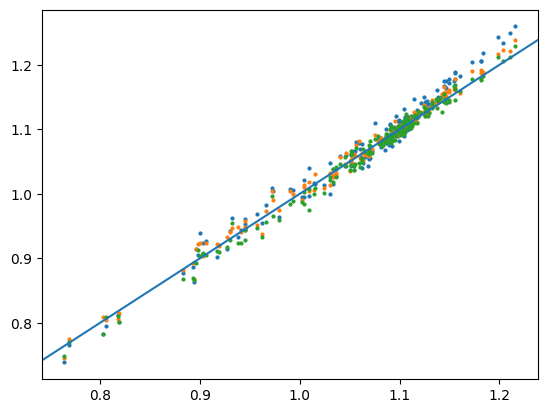

In [113]:
ratio = (frame[:,1100:1300] / out.reshape((412,200)))[ind]
ratio2 = (frame2[:,1100:1300] / out2.reshape((412,200)))[ind]
ratio3 = (frame3[:,1100:1300] / out3.reshape((412,200)))[ind]
ratio4 = (frame4[:,1100:1300] / out4.reshape((412,200)))[ind]

plt.plot(ratio4, ratio, 'o',ms=2)
plt.plot(ratio4, ratio2, 'o',ms=2)
plt.plot(ratio4, ratio3, 'o',ms=2)


plt.axline([1,1], slope=1)


In [114]:
ratios = [ratio, ratio2, ratio3]

for r in ratios:
    fit = np.polyfit(ratio4, r, 1)
    print(fit)

[ 1.05539603 -0.05411888]
[ 1.01133008 -0.01001786]
[ 1.03887196 -0.04308283]


In [128]:
r = (frame[:,1100:1300] / out.reshape((412,200)))
r2 = (frame2[:,1100:1300] / out2.reshape((412,200)))
r3 = (frame3[:,1100:1300] / out3.reshape((412,200)))
r4 = (frame4[:,1100:1300] / out4.reshape((412,200)))

idx = (r < 1.3) & (r > 0.7)

/tmp/ipykernel_1483775/2398455739.py:1: RuntimeWarning: divide by zero encountered in divide
  r = (frame[:,1100:1300] / out.reshape((412,200)))
/tmp/ipykernel_1483775/2398455739.py:1: RuntimeWarning: invalid value encountered in divide
  r = (frame[:,1100:1300] / out.reshape((412,200)))
/tmp/ipykernel_1483775/2398455739.py:2: RuntimeWarning: divide by zero encountered in divide
  r2 = (frame2[:,1100:1300] / out2.reshape((412,200)))
/tmp/ipykernel_1483775/2398455739.py:2: RuntimeWarning: invalid value encountered in divide
  r2 = (frame2[:,1100:1300] / out2.reshape((412,200)))
/tmp/ipykernel_1483775/2398455739.py:3: RuntimeWarning: divide by zero encountered in divide
  r3 = (frame3[:,1100:1300] / out3.reshape((412,200)))
/tmp/ipykernel_1483775/2398455739.py:3: RuntimeWarning: invalid value encountered in divide
  r3 = (frame3[:,1100:1300] / out3.reshape((412,200)))
/tmp/ipykernel_1483775/2398455739.py:4: RuntimeWarning: divide by zero encountered in divide
  r4 = (frame4[:,1100:1300] 

[0.97927641 0.02185305]


(0.7, 1.3)

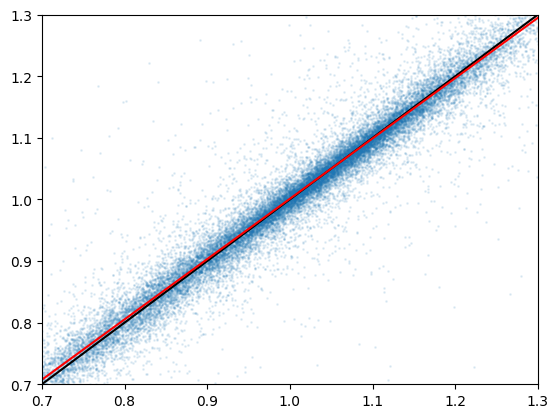

In [145]:
from astropy.stats import sigma_clip

_r1 = r3
_r2 = r4
plt.plot(_r1[idx].flatten(), _r2[idx].flatten(), 'o', ms=1, alpha=0.1)
poly = np.polyfit(_r1[idx].flatten(), _r2[idx].flatten(), 1)
# Perform sigma clipping
clipped_data = sigma_clip(_r1[idx].flatten(), sigma=2, maxiters=5)

# Use the clipped data for fitting
poly = np.polyfit(_r1[idx].flatten()[~clipped_data.mask], _r2[idx].flatten()[~clipped_data.mask], 1)
plt.axline([1,1],slope=1, color='black')
plt.plot(np.arange(3),np.poly1d(poly)(np.arange(3)), color='red')
print(poly)
plt.xlim([0.7,1.3])
plt.ylim([0.7,1.3])

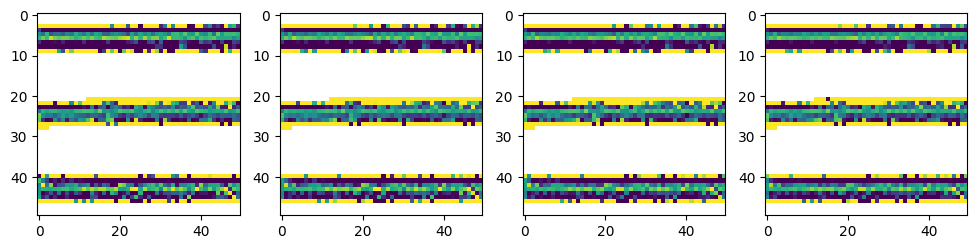

In [149]:
fig, axs = plt.subplots(ncols=4, figsize=(12,3))

rs = [r, r2, r3, r4]

for i, ax in enumerate(axs):
    ax.imshow(rs[i][:50,100:150],vmin=0.7,vmax=1.3)
# plt.imshow(r,vmin=0.7,vmax=1.3)
# plt.xlim([100,150])
# plt.ylim([0,50])

/tmp/ipykernel_1483775/469766620.py:1: RuntimeWarning: divide by zero encountered in divide
  flat1 = (frame[:,1100:1300] / out.reshape((412,200)))
/tmp/ipykernel_1483775/469766620.py:1: RuntimeWarning: invalid value encountered in divide
  flat1 = (frame[:,1100:1300] / out.reshape((412,200)))


(0.0, 50.0)

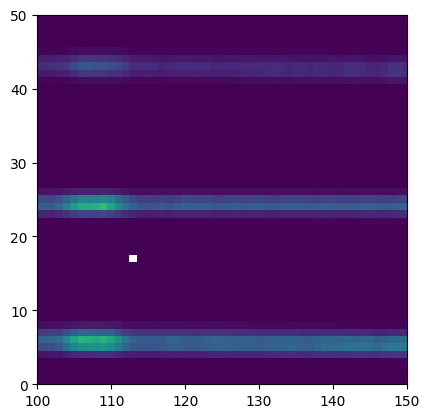

In [153]:
flat1 = (frame[:,1100:1300] / out.reshape((412,200)))

plt.imshow(frame[:,1100:1300] / flat1)
plt.xlim([100,150])
plt.ylim([0,50])

In [154]:
np.shape(frame)

(412, 1896)

In [155]:
flatframe = np.zeros((412,1896))
flatframe[:,1100:1300] = flat1

In [164]:
spec4_cor, res4_cor = sp.frame_to_spec(frame4/flatframe, xmin, xmax, sm2.wav_map, matrix = sm2.A, return_residual = True)


/tmp/ipykernel_1483775/220626419.py:1: RuntimeWarning: divide by zero encountered in divide
  spec4_cor, res4_cor = sp.frame_to_spec(frame4/flatframe, xmin, xmax, sm2.wav_map, matrix = sm2.A, return_residual = True)
/tmp/ipykernel_1483775/220626419.py:1: RuntimeWarning: invalid value encountered in divide
  spec4_cor, res4_cor = sp.frame_to_spec(frame4/flatframe, xmin, xmax, sm2.wav_map, matrix = sm2.A, return_residual = True)


In [159]:
np.shape(res_cor)

(412, 200)

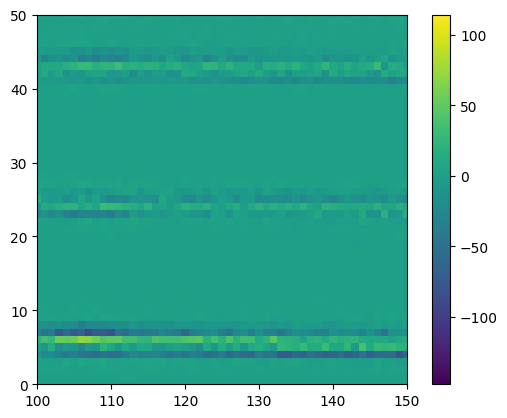

In [166]:
plt.imshow(res4)
plt.xlim([100,150])
plt.ylim([0,50])
plt.colorbar()

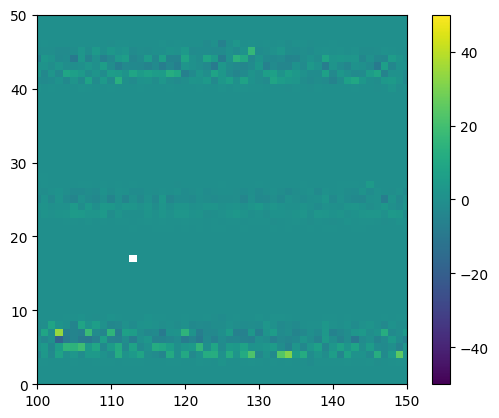

In [168]:
plt.imshow(res4_cor, vmin=-50,vmax=50)
plt.xlim([100,150])
plt.ylim([0,50])
plt.colorbar()

In [169]:
np.shape(spec4_cor)

(38, 200)

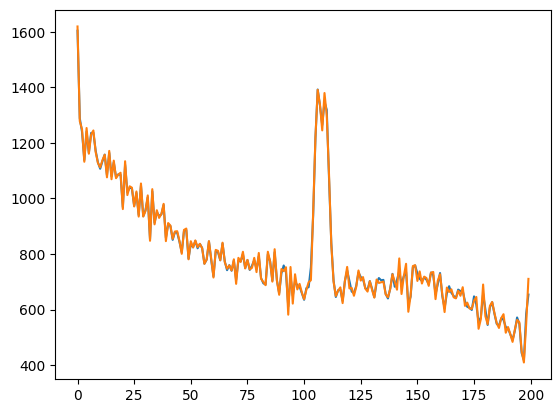

In [171]:
plt.plot(spec4_cor[0])
plt.plot(spec4[0])

In [17]:
target_chunk5 = fits.getdata('/mnt/datazpool/PL/20240917/firstpl/firstpl_14:54:17.025254111.fits')

target_chunk6 = fits.getdata('/mnt/datazpool/PL/20240917/firstpl/firstpl_14:53:37.007616295.fits')

In [18]:
# target_chunk2 = fits.getdata('/mnt/datazpool/PL/20240917/firstpl/firstpl_15:00:37.192645603.fits')

from tqdm import tqdm
_frame2s, _res2s = [], []
for i in tqdm(range(50)):
    _frame2 = np.mean(target_chunk[20*i:20*(i+1)],axis=0) - avgdark
    _spec2, _res2 = sp.frame_to_spec(_frame2, xmin, xmax, sm2.wav_map, matrix = sm2.A, return_residual = True)
    _res2s.append(_res2)
    _frame2s.append(_frame2[:,1100:1300])

for i in tqdm(range(50)):
    _frame2 = np.mean(target_chunk2[20*i:20*(i+1)],axis=0) - avgdark
    _spec2, _res2 = sp.frame_to_spec(_frame2, xmin, xmax, sm2.wav_map, matrix = sm2.A, return_residual = True)
    _res2s.append(_res2)
    _frame2s.append(_frame2[:,1100:1300])

for i in tqdm(range(50)):
    _frame2 = np.mean(target_chunk3[20*i:20*(i+1)],axis=0) - avgdark
    _spec2, _res2 = sp.frame_to_spec(_frame2, xmin, xmax, sm2.wav_map, matrix = sm2.A, return_residual = True)
    _res2s.append(_res2)
    _frame2s.append(_frame2[:,1100:1300])

for i in tqdm(range(50)):
    _frame2 = np.mean(target_chunk4[20*i:20*(i+1)],axis=0) - avgdark
    _spec2, _res2 = sp.frame_to_spec(_frame2, xmin, xmax, sm2.wav_map, matrix = sm2.A, return_residual = True)
    _res2s.append(_res2)
    _frame2s.append(_frame2[:,1100:1300])

for i in tqdm(range(50)):
    _frame2 = np.mean(target_chunk5[20*i:20*(i+1)],axis=0) - avgdark
    _spec2, _res2 = sp.frame_to_spec(_frame2, xmin, xmax, sm2.wav_map, matrix = sm2.A, return_residual = True)
    _res2s.append(_res2)
    _frame2s.append(_frame2[:,1100:1300])

for i in tqdm(range(50)):
    _frame2 = np.mean(target_chunk6[20*i:20*(i+1)],axis=0) - avgdark
    _spec2, _res2 = sp.frame_to_spec(_frame2, xmin, xmax, sm2.wav_map, matrix = sm2.A, return_residual = True)
    _res2s.append(_res2)
    _frame2s.append(_frame2[:,1100:1300])

 24%|██▍       | 12/50 [00:00<00:02, 18.65it/s]

100%|██████████| 50/50 [00:02<00:00, 18.28it/s]


In [193]:
np.shape(_res2s)

(150, 412, 200)

In [178]:
np.shape(_frame2s)

(100, 412, 200)

[1.25826304e-04 1.04022885e+00]


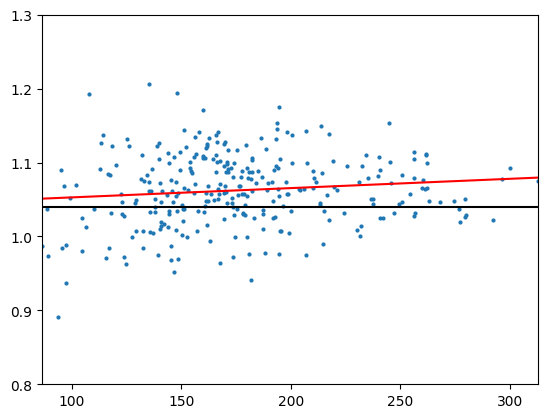

In [19]:
indx = 6
indy = 145 # 118
dd = np.array(_frame2s)[:,indx, indy]/(np.array(_frame2s)[:,indx, indy] - np.array(_res2s)[:,indx, indy])
plt.plot(np.array(_frame2s)[:,indx, indy], dd, 'o', ms=2)
poly = np.polyfit(np.array(_frame2s)[:,indx, indy], dd, deg = 1)
plt.plot(np.arange(1000),np.poly1d(poly)(np.arange(1000)), color='red')
plt.axhline(poly[1], color='black')
plt.xlim([np.min(np.array(_frame2s)[:,indx, indy]), np.max(np.array(_frame2s)[:,indx, indy])])
plt.ylim([0.8,1.3])

print(poly)
# plt.axhline(0)

[-6.45366306e-05  1.17013812e+00]


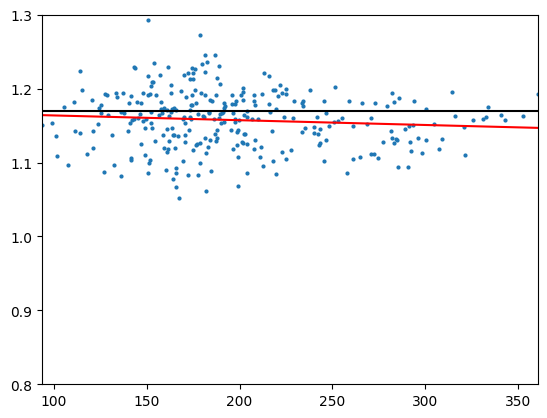

In [20]:
indx = 6
indy = 118
dd = np.array(_frame2s)[:,indx, indy]/(np.array(_frame2s)[:,indx, indy] - np.array(_res2s)[:,indx, indy])
plt.plot(np.array(_frame2s)[:,indx, indy], dd, 'o', ms=2)
poly = np.polyfit(np.array(_frame2s)[:,indx, indy], dd, deg = 1)
plt.plot(np.arange(1000),np.poly1d(poly)(np.arange(1000)), color='red')
plt.axhline(poly[1], color='black')
plt.xlim([np.min(np.array(_frame2s)[:,indx, indy]), np.max(np.array(_frame2s)[:,indx, indy])])
plt.ylim([0.8,1.3])

print(poly)
# plt.axhline(0)

[1.97877807e-04 1.01961849e+00]


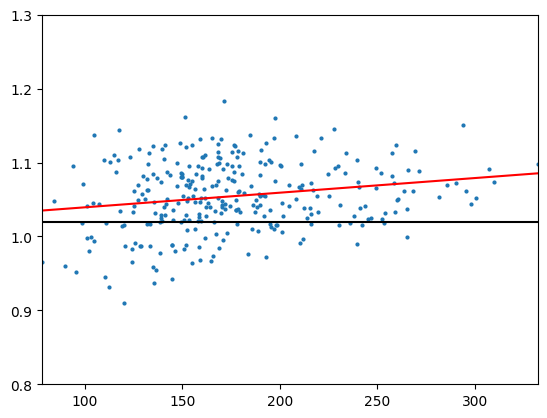

In [ ]:
indx = 6
indy = 144 # 118

# measured / (measured - residual) = measured / model
dd = np.array(_frame2s)[:,indx, indy]/(np.array(_frame2s)[:,indx, indy] - np.array(_res2s)[:,indx, indy])
plt.plot(np.array(_frame2s)[:,indx, indy], dd, 'o', ms=2)
poly = np.polyfit(np.array(_frame2s)[:,indx, indy], dd, deg = 1)
plt.plot(np.arange(1000),np.poly1d(poly)(np.arange(1000)), color='red')
plt.axhline(poly[1], color='black')
plt.xlim([np.min(np.array(_frame2s)[:,indx, indy]), np.max(np.array(_frame2s)[:,indx, indy])])
plt.ylim([0.8,1.3])

print(poly)
# plt.axhline(0)

[-1.91157174e-04  9.83928763e-01]


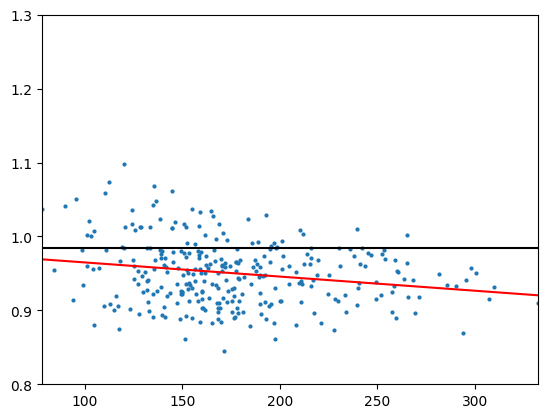

In [22]:
indx = 6
indy = 144 # 118

# model / measured
dd = 1/(np.array(_frame2s)[:,indx, indy]/(np.array(_frame2s)[:,indx, indy] - np.array(_res2s)[:,indx, indy]))
plt.plot(np.array(_frame2s)[:,indx, indy], dd, 'o', ms=2)
poly = np.polyfit(np.array(_frame2s)[:,indx, indy], dd, deg = 1)
plt.plot(np.arange(1000),np.poly1d(poly)(np.arange(1000)), color='red')
plt.axhline(poly[1], color='black')
plt.xlim([np.min(np.array(_frame2s)[:,indx, indy]), np.max(np.array(_frame2s)[:,indx, indy])])
plt.ylim([0.8,1.3])

print(poly)
# plt.axhline(0)